In [1]:

import os
import glob
import imageio
import logging
import numpy as np
import cupy as cp
import time
from numba import cuda, vectorize, float32
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

def load_mri_images(subfolder='001'):
    """Load MRI images from the specified subfolder"""
    try:
        folders = os.path.join('adni_png', subfolder)
        if not os.path.exists(folders):
            raise FileNotFoundError(f"MRI image folder not found: {folders}")
        
        files = sorted(glob.glob(f"{folders}/*.png"))
        if not files:
            raise FileNotFoundError(f"No MRI images found in {folders}")
        
        images = np.array([imageio.imread(f) for f in files], dtype=np.float32)
        names = [f[-17:-4] for f in files]
        logger.info(f"Successfully loaded {len(images)} MRI images from {subfolder}")
        return images, names
    except Exception as e:
        logger.error(f"Error loading MRI images: {str(e)}")
        raise

# HPC Mini-Challenge 2 - Acceleration in Data Science
## Part 2: GPU
#### FHNW - FS2024

Original by S. Suter, adapted by S. Marcin and M. Stutz

Submitted by: <font color='blue'>insert name here</font>

#### Resources
* [GPU Programming Overview](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Lectures and examples from the computer science course PAC (parallel computing), see folder "resources"
* CSCS "High-Performance Computing with Python" course, day 3:
- JIT Numba GPU 1 + 2
- https://youtu.be/E4REVbCVxNQ
- https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
- See also current tutorial from 2021
* [Google CoLab](https://colab.research.google.com/) or own GPU if necessary.


## 5 GPU reconstruction

Implement an SVD reconstruction variant on the GPU or in a hybrid setting. Code from the first part may be used. Choose consciously which parts of the algorithm are implemented in a GPU kernel and which are more efficient on the CPU. Include findings from the first part. At least one component of the algorithm must be implemented in a GPU kernel. Document any assumptions you make for simplification. Evaluate whether you want to work with CuPy or Numba.

Links:
* [Examples: Matrix multiplication](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [2]:
import math
import numpy as np
import cupy as cp
from numba import cuda
import time
import matplotlib.pyplot as plt
import timeit

# todo 1
def reconstruct_svd_broadcast1(u,s,vt,k):
    ### BEGIN SOLUTION
    reco = u[:,:k] * s[:k] @ vt[:k,:]
    ### END SOLUTION
    return reco

def reconstruct_svd_cp(u, s, vt, k):
    """
    Perform SVD reconstruction using CuPy's built-in dot product.
    """
    return cp.asnumpy(cp.dot(u[:,:k], cp.dot(cp.diag(s[:k]), vt[:k,:])))

def reconstruct_svd_cp_einsum(u, s, vt, k):
    """
    Perform SVD reconstruction using CuPy and einsum for matrix multiplication.
    """
    return cp.asnumpy(cp.einsum('ik,k,kj->ij', u[:,:k], s[:k], vt[:k,:]))

def reconstruct_svd_cp_broadcast(u, s, vt, k):
    """
    CuPy SVD reconstruction using broadcasting for the multiplication of S.
    """
    return cp.asnumpy(cp.dot(u[:,:k], cp.multiply(s[:k].reshape(-1, 1), vt[:k,:])))

@cuda.jit
def reconstruct_svd_kernel(u, s, vt, out, k):
    """
    CUDA kernel that reconstructs a matrix from SVD components:
      out = u * s * vt, up to rank k.
    """
    i, j = cuda.grid(2)
    if i < u.shape[0] and j < vt.shape[1]:
        tmp = 0.0
        for r in range(k):
            tmp += u[i, r] * s[r] * vt[r, j]
        out[i, j] = tmp

def reconstruct_svd_numba(u, s, vt, k):
    """
    Multiply U, S, and V^T on the GPU using a custom CUDA kernel.
    """
    U_k = u[:,:k]
    S_k = s[:k]
    VT_k = vt[:k,:]

    # Prepare output on GPU
    out = np.zeros((U_k.shape[0], VT_k.shape[1]), dtype=np.float32)

    # Launch kernel
    threads_per_block = (16, 16)
    blocks_per_grid = (
        math.ceil(U_k.shape[0] / threads_per_block[0]),
        math.ceil(VT_k.shape[1] / threads_per_block[1])
    )
    reconstruct_svd_kernel[blocks_per_grid, threads_per_block](U_k, S_k, VT_k, out, S_k.shape[0])
    return out

/tmp/ipykernel_49800/3479325960.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = np.array([imageio.imread(f) for f in files], dtype=np.float32)
/home/paperspace/hs24-mc2-dmnkf/.venv/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


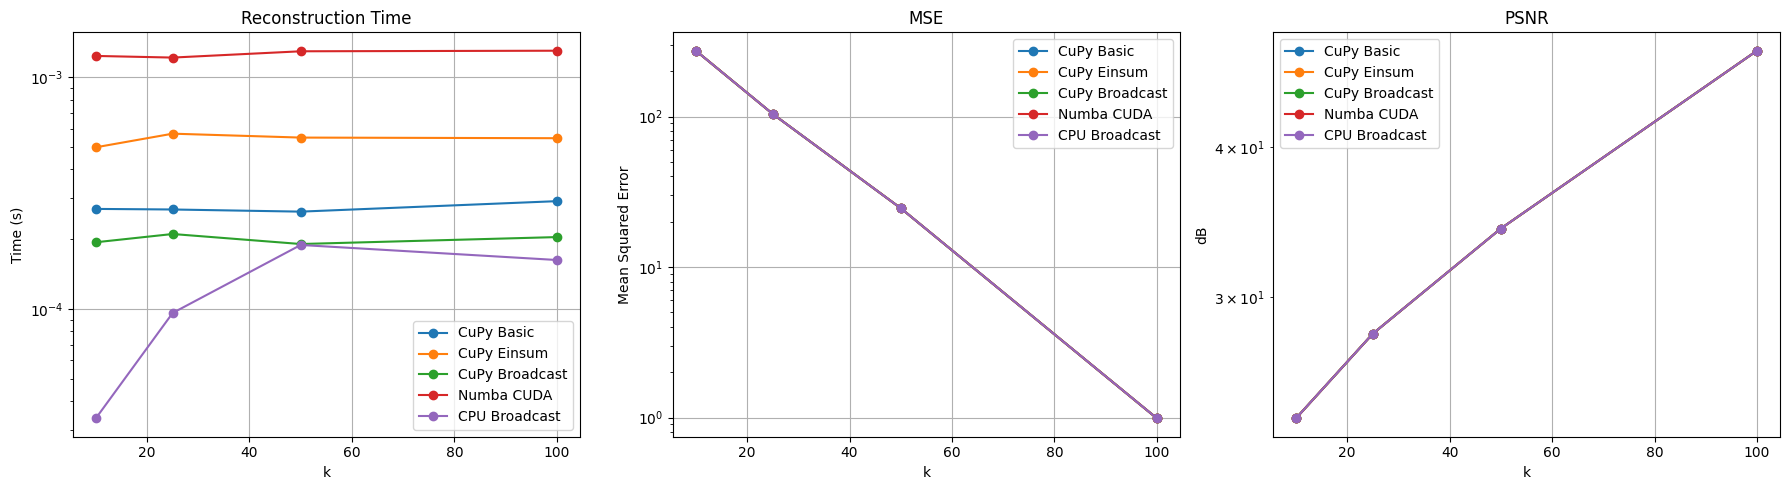

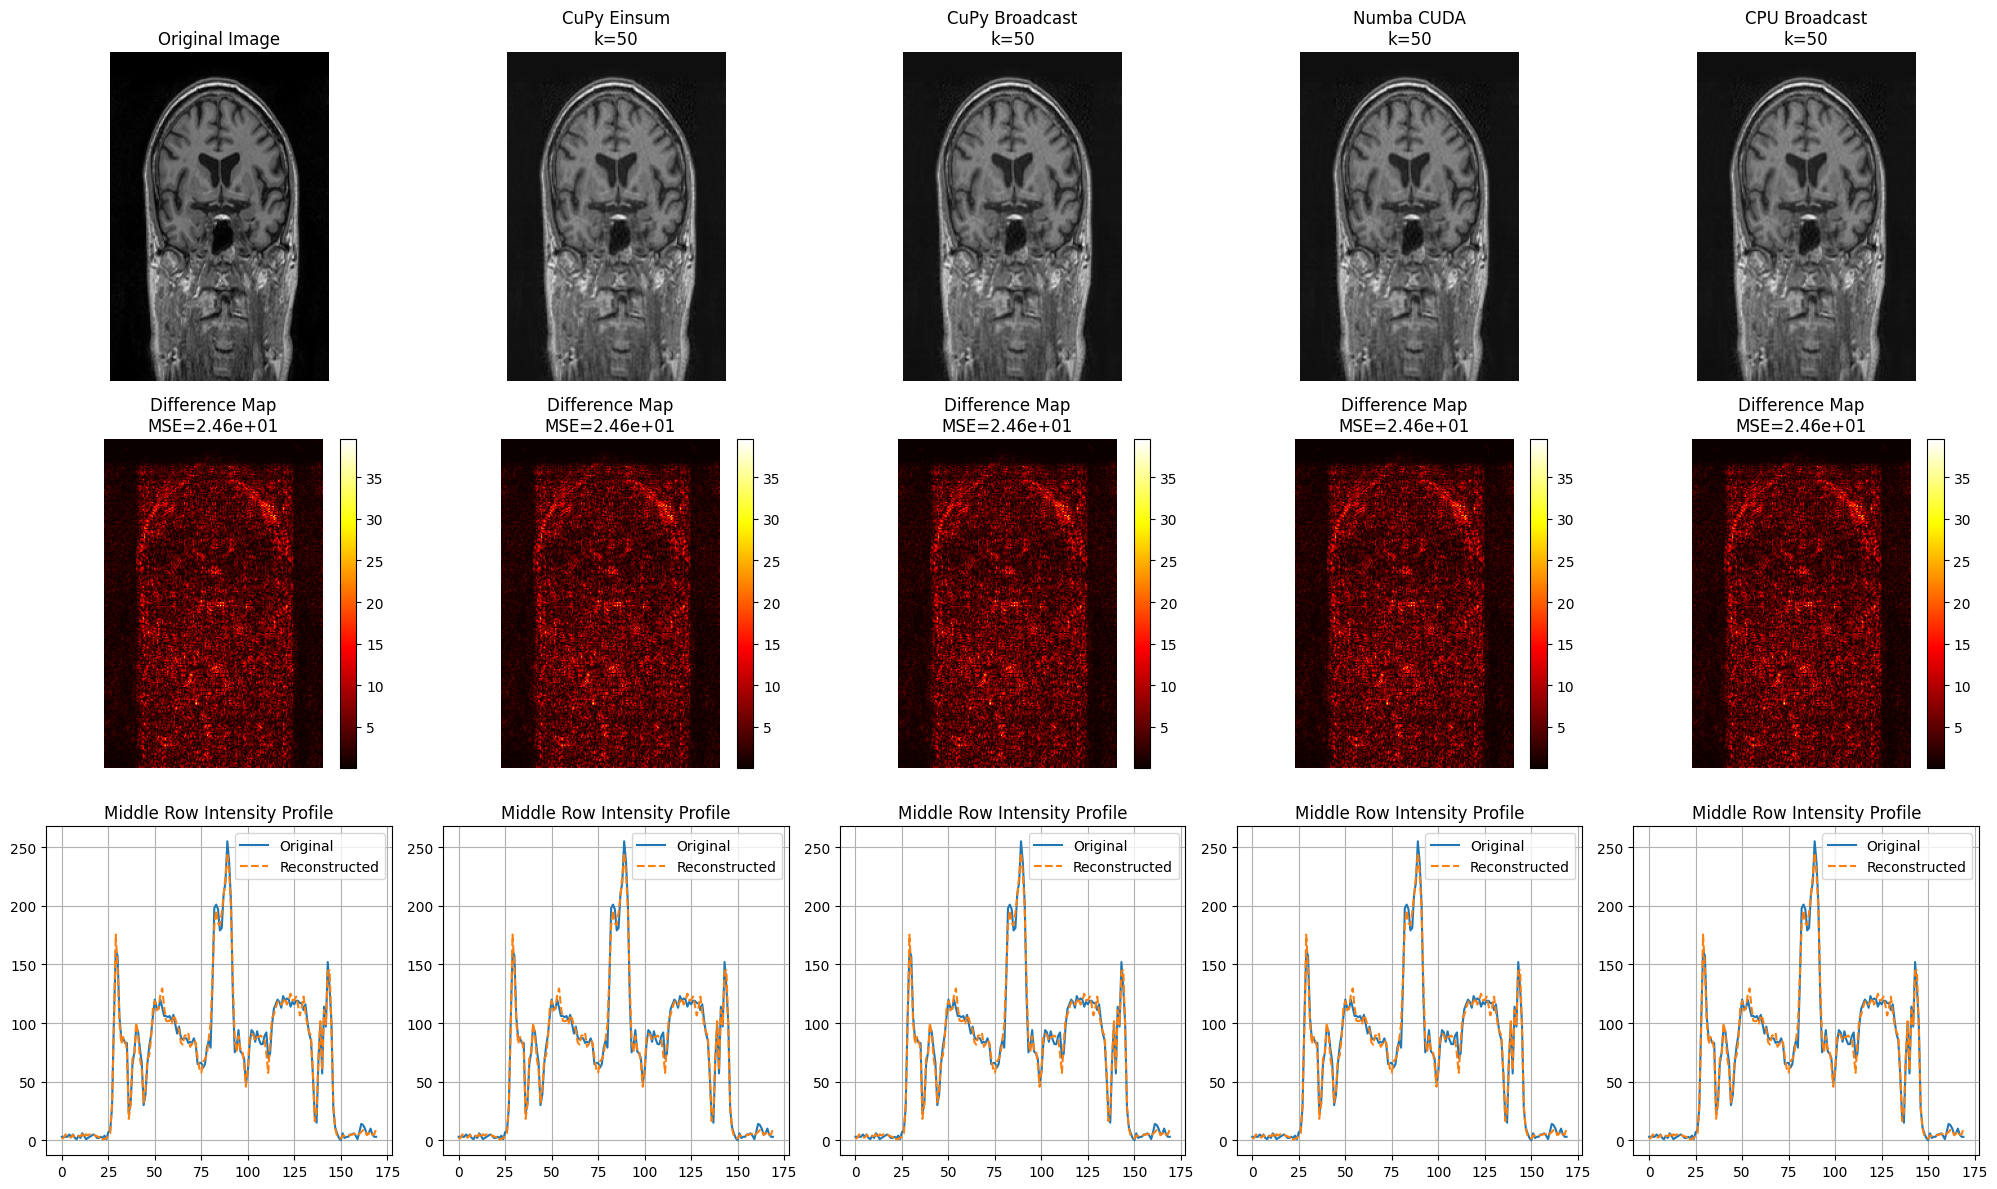

In [3]:

def measure_metrics(original, reconstructed):
    """
    Compute MSE and PSNR for the given original and reconstructed images.
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:  # Perfect reconstruction
        psnr = float('inf')
    else:
        psnr = round(20 * np.log10(255.0 / np.sqrt(mse)), 5)
    return mse, psnr

def plot_reconstruction_comparison(test_image, k_values=(10, 25, 50, 100)):
    """
    For each method, reconstruct the test_image with various k-values,
    measuring decomposition and reconstruction times separately.
    """
    implementations = {
        'CuPy Basic': reconstruct_svd_cp,
        'CuPy Einsum': reconstruct_svd_cp_einsum,
        'CuPy Broadcast': reconstruct_svd_cp_broadcast,
        'Numba CUDA': reconstruct_svd_numba,
        'CPU Broadcast': reconstruct_svd_broadcast1,
    }

    results = {name: [] for name in implementations}

    # Perform SVD decomposition once
    U, S, VT = np.linalg.svd(test_image, full_matrices=False)

    # Pre-transfer data to GPU for GPU implementations
    U_gpu = cp.asarray(U, dtype=cp.float32)
    S_gpu = cp.asarray(S, dtype=cp.float32)
    VT_gpu = cp.asarray(VT, dtype=cp.float32)

    for k in k_values:
        first_mse = None
        first_psnr = None
        
        for name, func in implementations.items():
            recon_times, mse_list, psnr_list = [], [], []
            
            # Prepare inputs based on implementation type
            if name == 'CPU Broadcast':
                u_input, s_input, vt_input = U, S, VT
            else:
                u_input, s_input, vt_input = U_gpu, S_gpu, VT_gpu
                # warmup
                func(u_input, s_input, vt_input, k)

            recon_time = timeit.timeit(
                lambda: func(u_input, s_input, vt_input, k),
                number=1000
            ) / 1000
            reconstructed = func(u_input, s_input, vt_input, k)
            
            mse, psnr = measure_metrics(test_image, reconstructed)
            
            # Store first MSE/PSNR values to compare against
            if first_mse is None:
                first_mse = mse
            else:
                # Assert that MSE and PSNR are equal across implementations
                assert np.allclose(mse, first_mse, rtol=1e-5), f"MSE mismatch for {name}"

            results[name].append({
                'k': k,
                'recon_time': recon_time,
                'mse': mse,
                'psnr': psnr,
                'reconstructed': reconstructed
            })

    # Plot reconstruction time, MSE, PSNR
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for name, data in results.items():
        k_list = [d['k'] for d in data]
        recon_times = [d['recon_time'] for d in data]
        mse_list = [d['mse'] for d in data]
        psnr_list = [d['psnr'] for d in data]

        axes[0].plot(k_list, recon_times, '-o', label=name)
        axes[1].plot(k_list, mse_list, '-o', label=name)
        axes[2].plot(k_list, psnr_list, '-o', label=name)

    axes[0].set_title('Reconstruction Time')
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Time (s)')
    axes[0].set_yscale('log')

    axes[1].set_title('MSE')
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Mean Squared Error')
    # log scale
    axes[1].set_yscale('log')

    axes[2].set_title('PSNR')
    axes[2].set_xlabel('k')
    axes[2].set_ylabel('dB')
    # log scale
    axes[2].set_yscale('log')

    for ax in axes:
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot reconstructions and difference maps for k=50
    k_idx = k_values.index(50)  # Get index of k=50 results
    
    # Create figure with subplots
    n_methods = len(implementations)
    fig, axes = plt.subplots(3, n_methods, figsize=(4*n_methods, 12))
    
    # Plot original image in first row, first column
    axes[0,0].imshow(test_image, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')
    
    for idx, (name, method_results) in enumerate(results.items()):
        reconstructed = method_results[k_idx]['reconstructed']
        diff_map = np.abs(test_image - reconstructed)
        
        # Plot reconstructed image
        if idx > 0:  # Skip first column of first row (used for original)
            axes[0,idx].imshow(reconstructed, cmap='gray')
            axes[0,idx].set_title(f'{name}\nk=50')
            axes[0,idx].axis('off')
        
        # Plot difference map
        im = axes[1,idx].imshow(diff_map, cmap='hot')
        axes[1,idx].set_title(f'Difference Map\nMSE={method_results[k_idx]["mse"]:.2e}')
        axes[1,idx].axis('off')
        plt.colorbar(im, ax=axes[1,idx])
        
        # Plot intensity profile
        middle_row = test_image.shape[0]//2
        axes[2,idx].plot(test_image[middle_row,:], label='Original')
        axes[2,idx].plot(reconstructed[middle_row,:], '--', label='Reconstructed')
        axes[2,idx].set_title('Middle Row Intensity Profile')
        axes[2,idx].legend()
        axes[2,idx].grid(True)
    
    plt.tight_layout()
    plt.show()

images, names = load_mri_images(subfolder='001')
test_image = np.ascontiguousarray(images[0])

plot_reconstruction_comparison(test_image)

TODO 

#### 5.2 GPU Kernel Performance

##### 5.2.1 Blocks and input size

Left:
* [Examples: Matrix Multiplication](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA chapter on "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Carry out 2-3 experiments with different block configurations and sizes of input data. Create a new data set with arbitrarily large matrices, as the GPU is particularly suitable for processing large inputs (use these different sized matrices for all subsequent comparisons and tasks as well). Measure the performance of the GPU kernel using suitable functions. Based on your experiments, which block size in relation to the input size has proven to be the most successful? What do you think are the reasons for this? What are the performance differences between your CPU and GPU implementation? Discuss your analysis (with graphs if necessary).

In [4]:
# matrix_sizes = [512, 1024, 2048, 4096, 8192]
matrix_sizes = [512, 1024, 2048, 4096]


# Block configurations to test - powers of 2, respecting max 1024 threads
block_configs = [
    (x, y) for x, y in [
        (2**i, 2**j) 
        for i in range(1,6) 
        for j in range(1,9)
    ] if x * y <= 1024 and x <= y
]


# Precompute SVD decompositions for each matrix size
svd_components = {}
for N in matrix_sizes:
    A = np.random.randn(N, N).astype(np.float32)
    u, s, vt = np.linalg.svd(A, full_matrices=False)
    k = min(u.shape[1], vt.shape[0]) // 3
    svd_components[N] = {
        'u': u,
        's': s,
        'vt': vt,
        'k': k
    }

    cpu_time = timeit.timeit(lambda: reconstruct_svd_broadcast1(u, s, vt, k), number=100) / 100
    
    svd_components[N]['cpu_time'] = cpu_time


In [5]:
results_basic = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    k = svd_components[N]['k']
    
    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        threadsperblock = block_size
        blockspergrid_x = math.ceil(N / threadsperblock[0])
        blockspergrid_y = math.ceil(N / threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        
        # Warm-up run
        reconstruct_svd_kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        reconstruct_svd_kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        stop_event.record()
        gpu_time = cuda.event_elapsed_time(start_event, stop_event) / 1000
        
        C_gpu = C_device.copy_to_host()
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_basic.append({
            'kernel': 'basic',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
        
    # Clean up device memory
    del u_device, s_device, vt_device, C_device

Block size (2, 2): GPU time = 0.0116s, Speedup = 0.05x
Block size (2, 4): GPU time = 0.0059s, Speedup = 0.10x
Block size (2, 8): GPU time = 0.0033s, Speedup = 0.18x
Block size (2, 16): GPU time = 0.0015s, Speedup = 0.39x
Block size (2, 32): GPU time = 0.0015s, Speedup = 0.39x
Block size (2, 64): GPU time = 0.0015s, Speedup = 0.38x
Block size (2, 128): GPU time = 0.0015s, Speedup = 0.38x
Block size (2, 256): GPU time = 0.0016s, Speedup = 0.37x
Block size (4, 4): GPU time = 0.0029s, Speedup = 0.20x
Block size (4, 8): GPU time = 0.0015s, Speedup = 0.39x
Block size (4, 16): GPU time = 0.0015s, Speedup = 0.39x
Block size (4, 32): GPU time = 0.0015s, Speedup = 0.39x
Block size (4, 64): GPU time = 0.0015s, Speedup = 0.38x
Block size (4, 128): GPU time = 0.0016s, Speedup = 0.37x
Block size (4, 256): GPU time = 0.0017s, Speedup = 0.35x
Block size (8, 8): GPU time = 0.0015s, Speedup = 0.39x
Block size (8, 16): GPU time = 0.0015s, Speedup = 0.39x
Block size (8, 32): GPU time = 0.0015s, Speedup = 

In [6]:
def plot_results(results, kernel_name):
    """
    Plot heatmaps and bar plots for each matrix size showing GPU times and CPU comparison.
    """
    # Extract unique sizes and configurations
    block_sizes = sorted(list(set([tuple(r['block_size']) for r in results])))
    matrix_sizes = sorted(list(set(r['matrix_size'] for r in results)))
    
    # Prepare data structures
    gpu_times = {}
    cpu_times = {}
    
    # Organize data
    for r in results:
        bs = tuple(r['block_size'])
        N = r['matrix_size']
        gpu_times.setdefault(bs, {})[N] = r['gpu_time']
        if N not in cpu_times:
            cpu_times[N] = r['cpu_time']
    
    # Create subplots for each matrix size
    for N in matrix_sizes:
        plt.figure(figsize=(18, 5))
        
        # --- Left subplot: Heatmap
        plt.subplot(1, 2, 1)
        
        # Extract block dimensions for heatmap axes
        block_x = sorted(list(set([bs[0] for bs in block_sizes])))
        block_y = sorted(list(set([bs[1] for bs in block_sizes])))
        
        # Create heatmap data - fill lower triangle
        heatmap_data = np.zeros((len(block_x), len(block_y)))
        for i, bx in enumerate(block_x):
            for j, by in enumerate(block_y):
                if (bx, by) in gpu_times and N in gpu_times[(bx, by)]:
                    heatmap_data[i,j] = gpu_times[(bx, by)][N]
                else:
                    heatmap_data[i,j] = np.nan
        
        # Find minimum time (excluding NaN values)
        min_time = np.nanmin(heatmap_data)
        
        plt.imshow(heatmap_data, cmap='magma_r', aspect='auto')  # Reversed colormap so lowest time is highlighted
        plt.colorbar(label='Time (s)')
        plt.title(f'{kernel_name} GPU Times Heatmap - Matrix Size {N}x{N}\nBest time: {min_time:.4f}s')
        plt.xlabel('Block Y Size')
        plt.ylabel('Block X Size')
        plt.xticks(range(len(block_y)), block_y)
        plt.yticks(range(len(block_x)), block_x)
        
        # Highlight the minimum value
        min_idx = np.where(heatmap_data == min_time)
        plt.plot(min_idx[1], min_idx[0], 'r*', markersize=15, label=f'Best: {min_time:.4f}s')
        plt.legend()
        
        # --- Right subplot: Bar plot
        plt.subplot(1, 2, 2)
        
        # Prepare data for bar plot
        gpu_times_N = []
        gpu_labels = []
        
        for bs in block_sizes:
            if N in gpu_times[bs]:
                gpu_times_N.append(gpu_times[bs][N])
                gpu_labels.append(f'Block {bs}')
        
        # Sort by execution time
        sorted_indices = np.argsort(gpu_times_N)
        sorted_times = [gpu_times_N[i] for i in sorted_indices]
        sorted_labels = [gpu_labels[i] for i in sorted_indices]
        
        # Create bar plot
        bars = plt.bar(range(len(sorted_times)), sorted_times)
        plt.xticks(range(len(sorted_times)), sorted_labels, rotation=45, ha='right')
        
        # Add CPU time reference line
        plt.axhline(y=cpu_times[N], color='r', linestyle='--', label=f'CPU Time')
        
        plt.yscale('log')
        plt.ylabel('Time (s)')
        plt.title(f'Execution Times - Matrix Size {N}x{N}')
        plt.grid(True, which='both', ls='-', alpha=0.2)
        plt.legend()
        
        plt.tight_layout()
        plt.show()



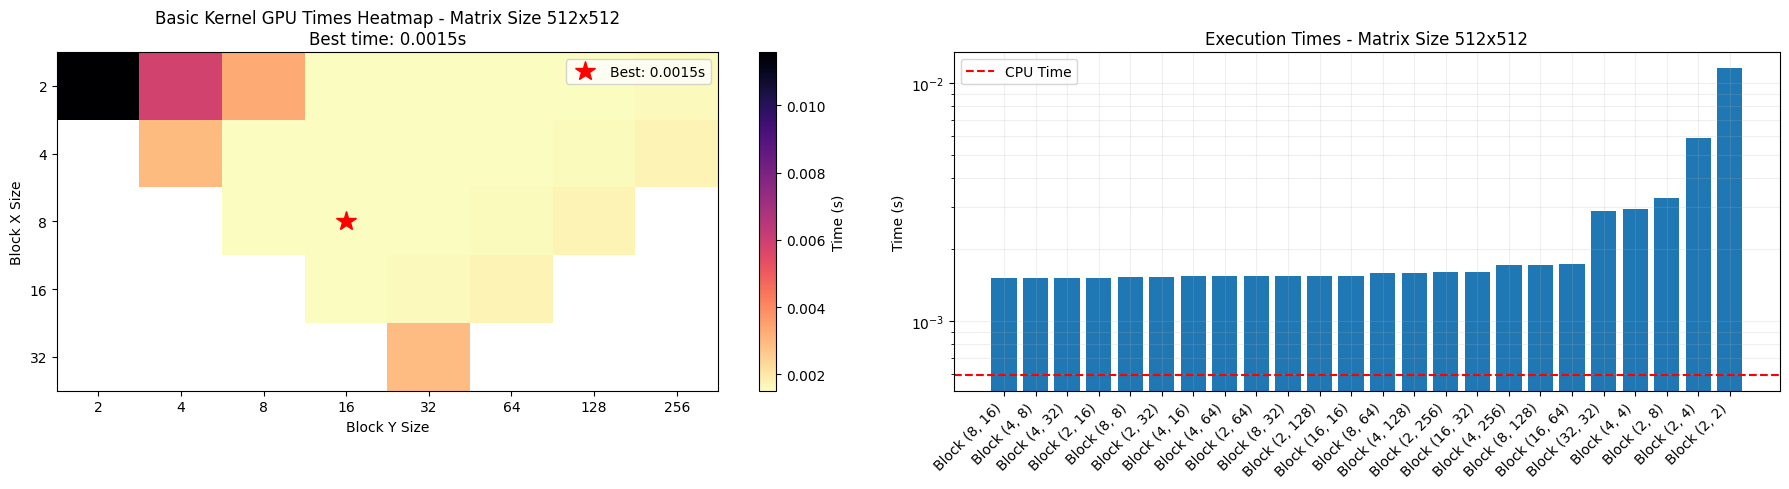

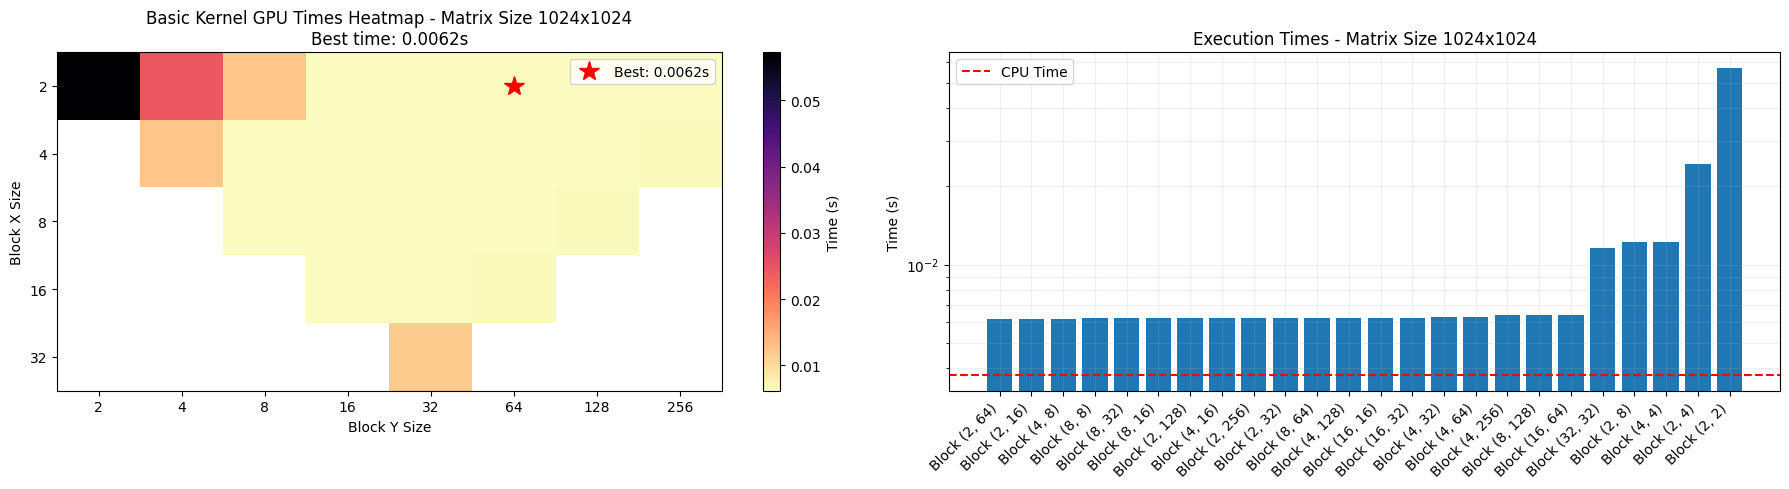

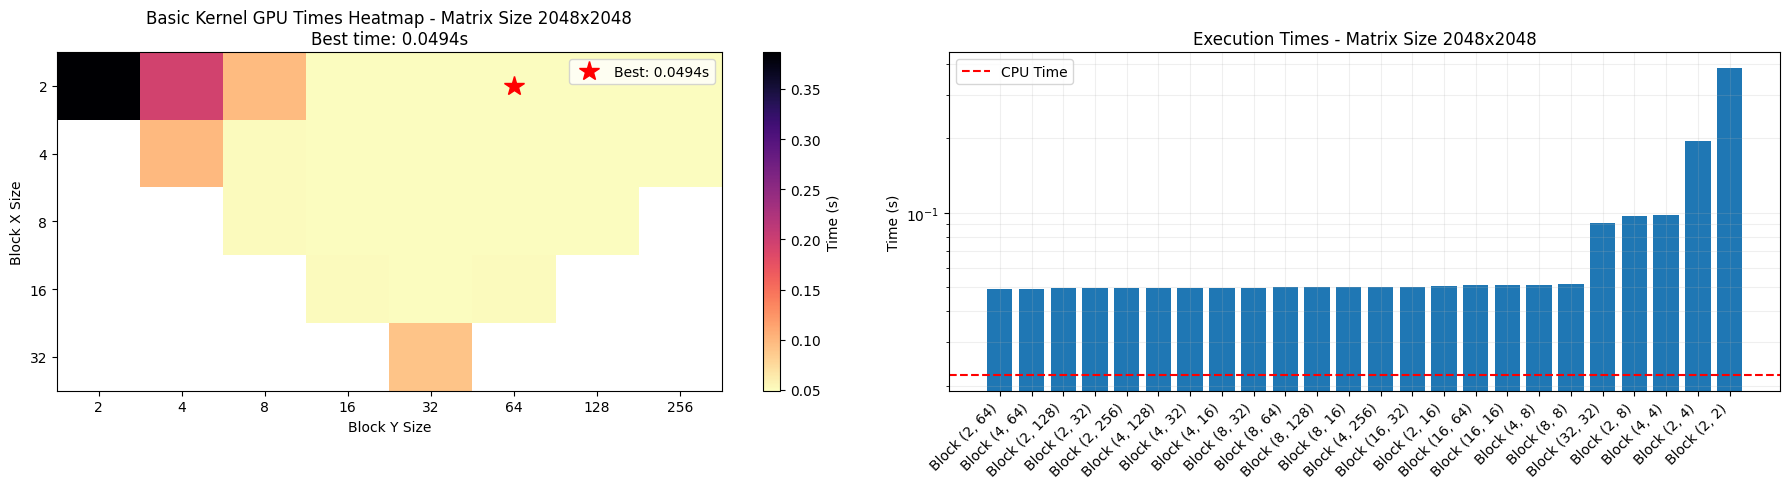

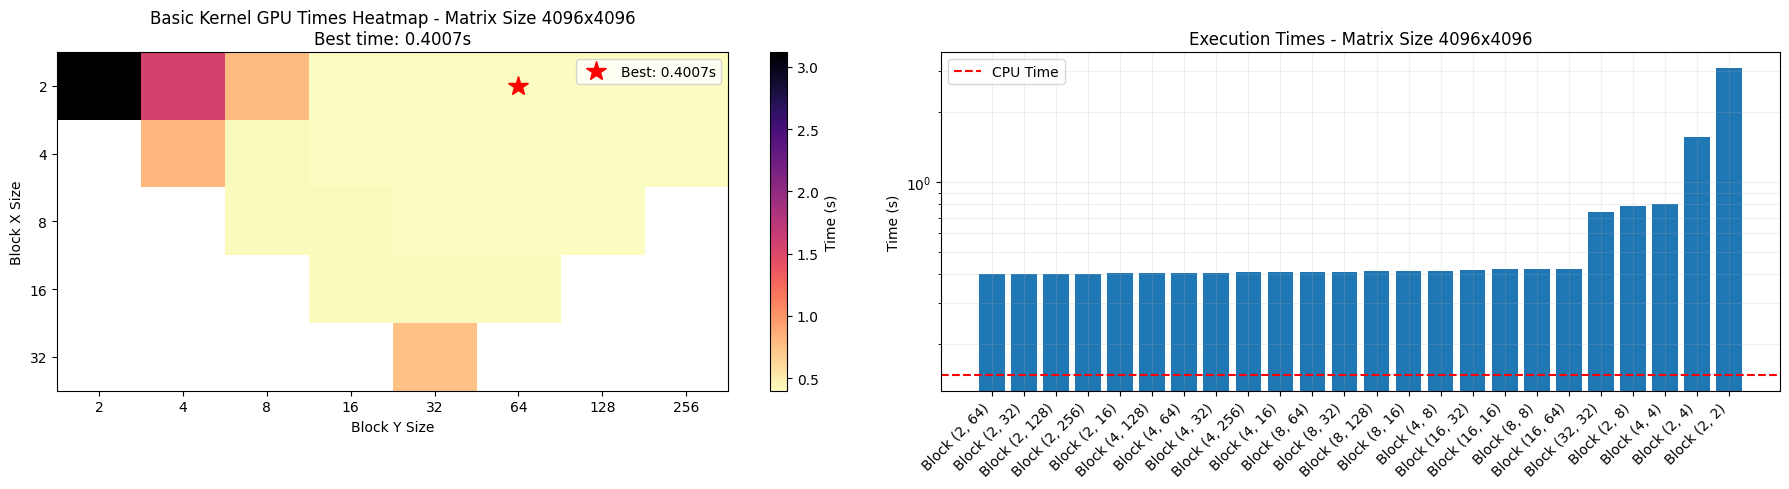


=== Best Configuration for Basic Kernel (Matrix Size 512x512) ===
Block Size: (8, 16)
GPU Time: 0.0015 seconds
Speedup over CPU: 0.39x

=== Best Configuration for Basic Kernel (Matrix Size 1024x1024) ===
Block Size: (2, 64)
GPU Time: 0.0062 seconds
Speedup over CPU: 0.61x

=== Best Configuration for Basic Kernel (Matrix Size 2048x2048) ===
Block Size: (2, 64)
GPU Time: 0.0494 seconds
Speedup over CPU: 0.45x

=== Best Configuration for Basic Kernel (Matrix Size 4096x4096) ===
Block Size: (2, 64)
GPU Time: 0.4007 seconds
Speedup over CPU: 0.37x


In [7]:
plot_results(results_basic, 'Basic Kernel')

for N in matrix_sizes:
    # Filter results for this matrix size
    results_N = [r for r in results_basic if r['matrix_size'] == N]
    best_basic = min(results_N, key=lambda x: x['gpu_time'])
    
    print(f"\n=== Best Configuration for Basic Kernel (Matrix Size {N}x{N}) ===")
    print(f"Block Size: {best_basic['block_size']}")
    print(f"GPU Time: {best_basic['gpu_time']:.4f} seconds") 
    print(f"Speedup over CPU: {best_basic['speedup']:.2f}x")

TODO

##### 5.2.2 Shared memory on the GPU
Optimize your implementation from above by using the shared memory of the GPU. Again, perform several experiments with different data sizes and evaluate the speedup compared to the CPU implementation.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplication and Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [8]:
import math
import numpy as np
from numba import cuda, float32

def get_kernel(threads_per_block):
    blockDimX, blockDimY = threads_per_block

    @cuda.jit
    def reconstruct_svd_numba_shared(u, s, vt, out, k):
        # Early exit if k <= 0
        if k <= 0:
            return

        # Map each thread to a global (i, j) in the output
        i = cuda.blockIdx.x * blockDimX + cuda.threadIdx.x
        j = cuda.blockIdx.y * blockDimY + cuda.threadIdx.y

        # Check boundaries
        if i >= out.shape[0] or j >= out.shape[1]:
            return

        # We chunk across the 'k' dimension in increments of blockDimX
        # We'll store partial slices of U, s, V^T in shared memory:
        #   - u_tile, vt_tile have shape=(blockDimX, blockDimY)
        #   - s_tile has shape=(blockDimX,)
        #
        # Explanation:
        #   * blockDim.x threads handle 'k' dimension chunking
        #   * blockDim.y threads help cover multiple output rows/cols in a block
        #   * Each thread loads one element of U and V^T (plus s) for a chunk

        u_tile  = cuda.shared.array(shape=(blockDimX, blockDimY), dtype=float32)
        vt_tile = cuda.shared.array(shape=(blockDimX, blockDimY), dtype=float32)
        s_tile  = cuda.shared.array(shape=(blockDimX,),           dtype=float32)

        # Thread-local coordinates
        tx = cuda.threadIdx.x  # used to index along the chunk dimension (k)
        ty = cuda.threadIdx.y

        # We'll accumulate the result for out[i, j] in 'acc'
        acc = float32(0.0)

        # Number of chunks to cover the entire k dimension
        num_chunks = (k + blockDimX - 1) // blockDimX

        for chunk_idx in range(num_chunks):
            # The base index in the k dimension for this chunk
            k_base = chunk_idx * blockDimX

            # 1) Load a portion of U into shared memory
            #    u_tile[tx, ty] = U[i, k_base + tx]  (if in range)
            col_u = k_base + tx
            if (col_u < k) and (i < u.shape[0]):
                u_tile[tx, ty] = u[i, col_u]
            else:
                u_tile[tx, ty] = 0.0

            # 2) Load a portion of V^T into shared memory
            #    vt_tile[tx, ty] = V^T[k_base + tx, j]
            row_vt = k_base + tx
            if (row_vt < vt.shape[0]) and (j < vt.shape[1]):
                vt_tile[tx, ty] = vt[row_vt, j]
            else:
                vt_tile[tx, ty] = 0.0

            # 3) Load the singular value slice into shared memory
            #    s_tile[tx] = s[row_vt], but only do it once per column of threads
            #    so we pick e.g. ty == 0
            if ty == 0:
                if row_vt < s.shape[0]:
                    s_tile[tx] = s[row_vt]
                else:
                    s_tile[tx] = 0.0

            # Synchronize to ensure the tile is fully loaded
            cuda.syncthreads()

            # 4) Accumulate partial sums across the chunk dimension
            #    We sum over n in [0..blockDimX), because that's how many threads in x loaded U, V^T, and s
            for n in range(blockDimX):
                # Only do the multiply-add if (k_base + n) is still in range
                if (k_base + n) < k:
                    acc += u_tile[n, ty] * s_tile[n] * vt_tile[n, ty]

            cuda.syncthreads()

        # Write final result to out[i, j]
        out[i, j] = acc

    return reconstruct_svd_numba_shared

In [9]:

# Store results
results_shared = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']

    
    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        threadsperblock = block_size
        blockspergrid_x = math.ceil(N / threadsperblock[0])
        blockspergrid_y = math.ceil(N / threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        print(f"blockspergrid: {blockspergrid}, threadsperblock: {threadsperblock}")
        
        kernel = get_kernel(threadsperblock)
        
        # # Warm-up run
        kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000

        
        # Copy result back to host
        C_gpu = C_device.copy_to_host()
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_shared.append({
            'kernel': 'shared',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
        
    # Clean up device memory
    del u_device, s_device, vt_device, C_device

blockspergrid: (256, 256), threadsperblock: (2, 2)
Block size (2, 2): GPU time = 0.0065s, Speedup = 0.09x
blockspergrid: (256, 128), threadsperblock: (2, 4)
Block size (2, 4): GPU time = 0.0033s, Speedup = 0.18x
blockspergrid: (256, 64), threadsperblock: (2, 8)
Block size (2, 8): GPU time = 0.0018s, Speedup = 0.34x
blockspergrid: (256, 32), threadsperblock: (2, 16)
Block size (2, 16): GPU time = 0.0010s, Speedup = 0.62x
blockspergrid: (256, 16), threadsperblock: (2, 32)
Block size (2, 32): GPU time = 0.0008s, Speedup = 0.71x
blockspergrid: (256, 8), threadsperblock: (2, 64)
Block size (2, 64): GPU time = 0.0008s, Speedup = 0.79x
blockspergrid: (256, 4), threadsperblock: (2, 128)
Block size (2, 128): GPU time = 0.0008s, Speedup = 0.74x
blockspergrid: (256, 2), threadsperblock: (2, 256)
Block size (2, 256): GPU time = 0.0009s, Speedup = 0.65x
blockspergrid: (128, 128), threadsperblock: (4, 4)
Block size (4, 4): GPU time = 0.0013s, Speedup = 0.46x
blockspergrid: (128, 64), threadsperblock

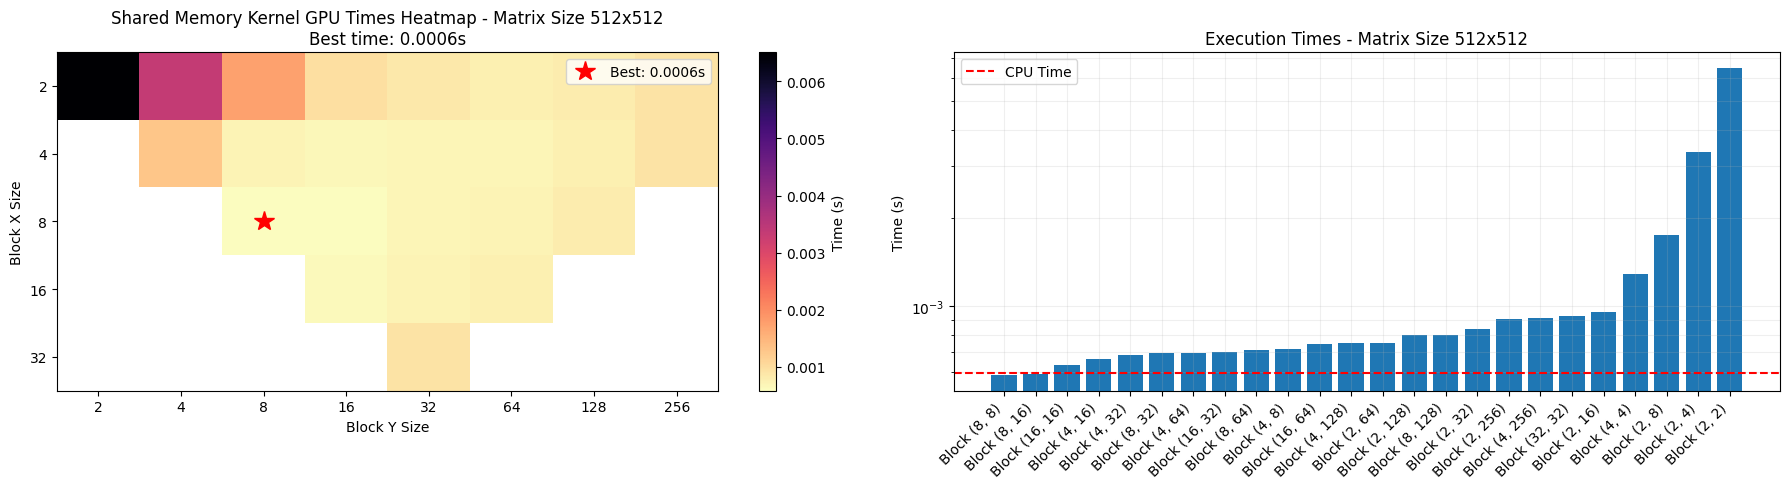

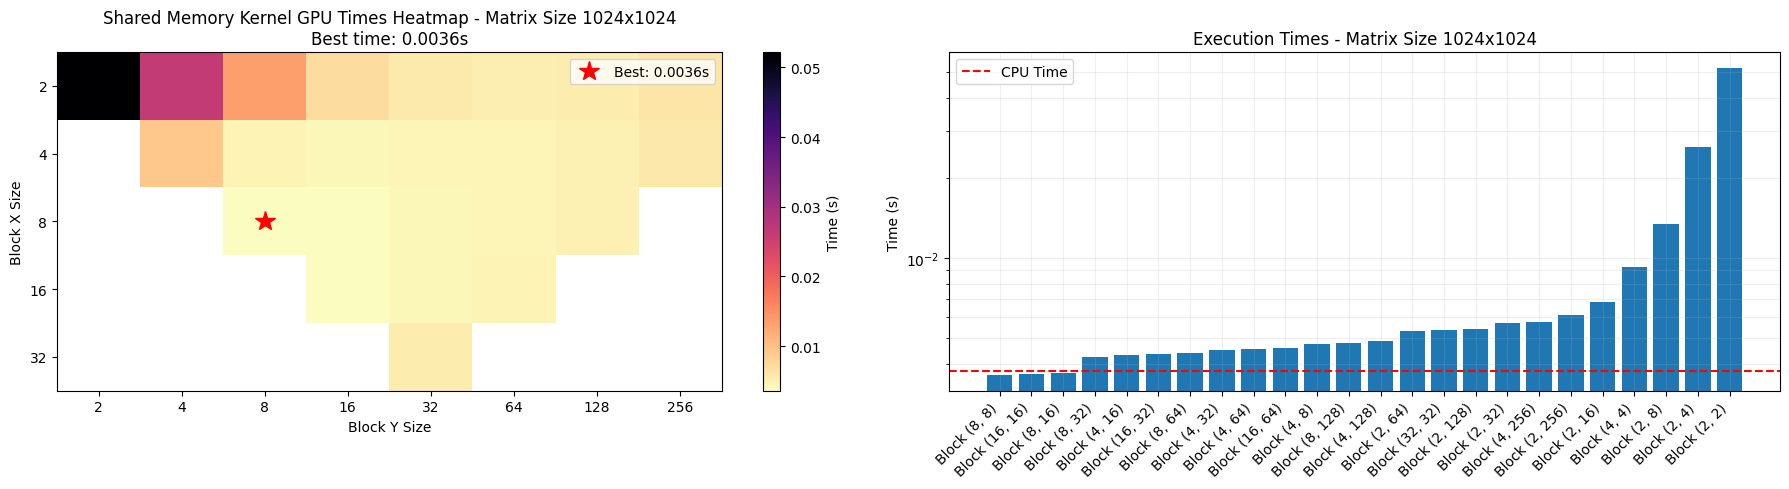

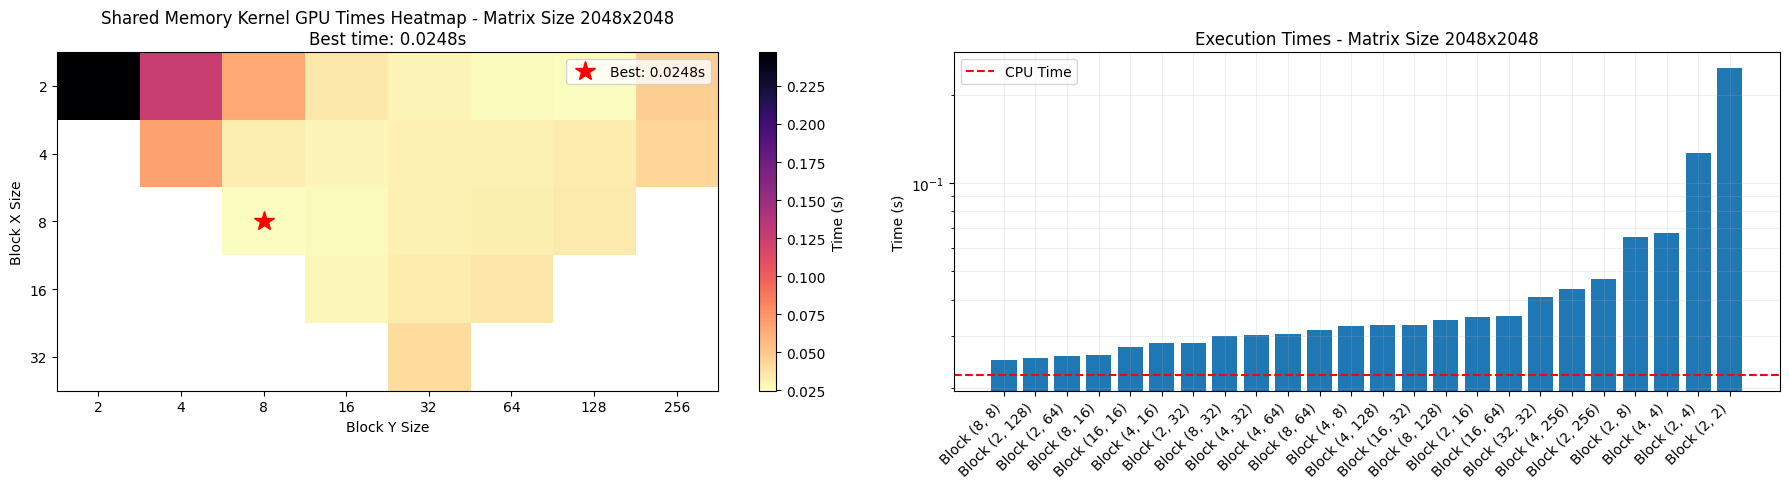

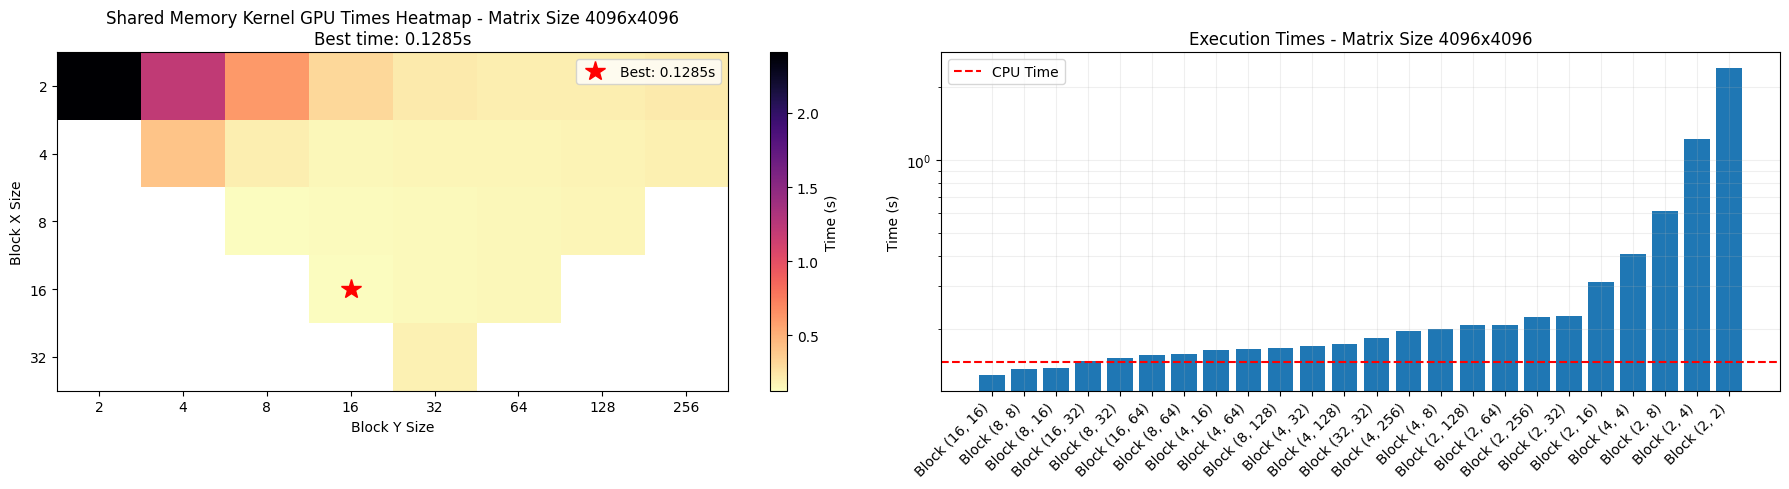

In [10]:
plot_results(results_shared, 'Shared Memory Kernel')

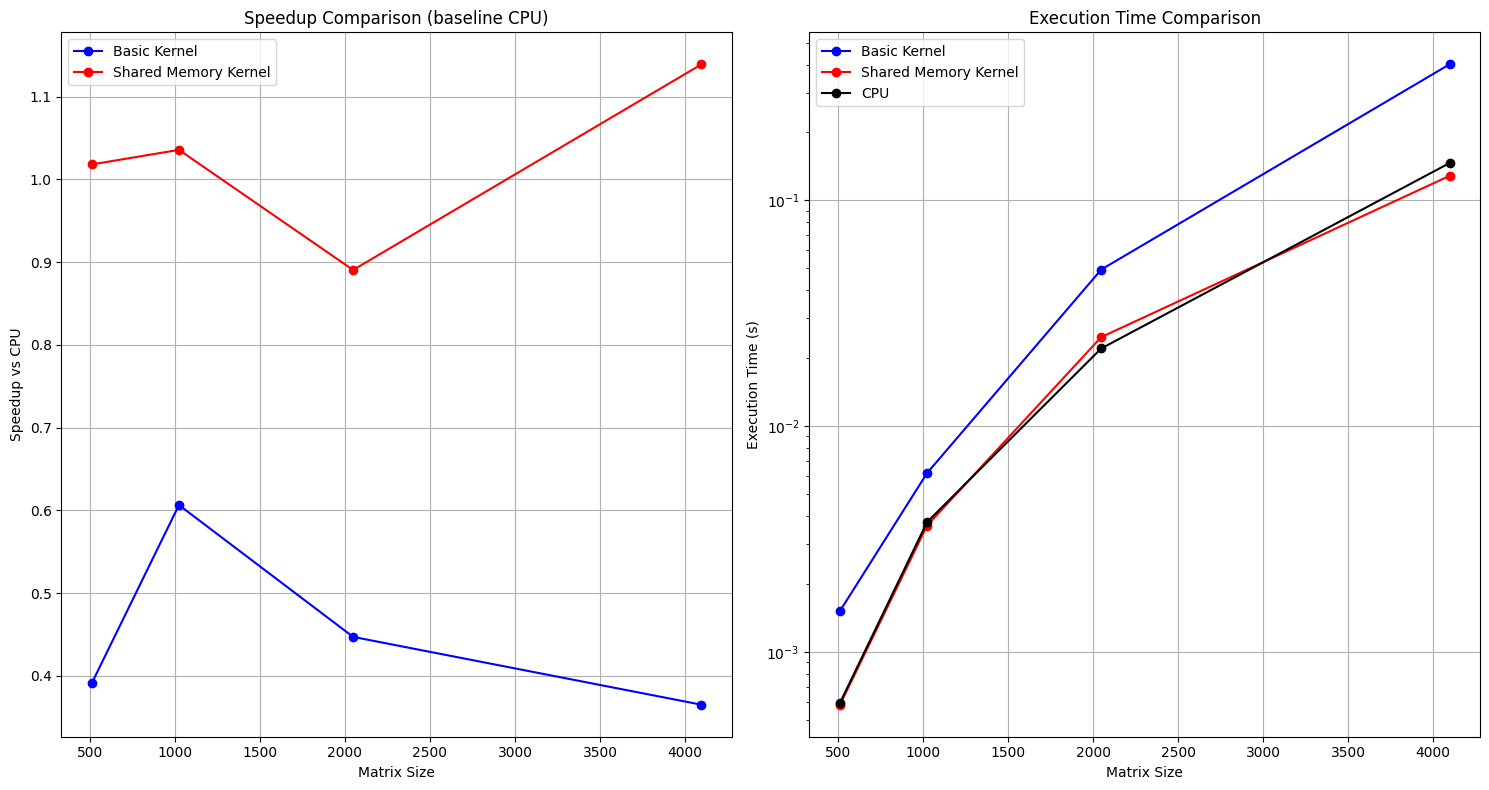


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0015    |    0.0006    | (8, 8)
    1024     |    0.0062    |    0.0036    | (8, 8)
    2048     |    0.0494    |    0.0248    | (8, 8)
    4096     |    0.4007    |    0.1285    | (16, 16)


In [11]:
def plot_kernel_comparison(best_times_list, labels, matrix_sizes):
    """
    Plot comparison of multiple kernel implementations
    
    Args:
        best_times_list: List of dictionaries containing best times for each implementation
        labels: List of labels for each implementation
        matrix_sizes: List of matrix sizes to plot
    """
    plt.figure(figsize=(15, 8))
    
    colors = ['b', 'r', 'g', 'c', 'm', 'y']  # Add more colors if needed
    
    # Plot speedups
    plt.subplot(1, 2, 1)
    for best_times, label, color in zip(best_times_list, labels, colors):
        plt.plot(matrix_sizes, [best_times[N]['speedup'] for N in matrix_sizes], 
                f'{color}-o', label=label)
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup vs CPU')
    plt.title('Speedup Comparison (baseline CPU)')
    plt.grid(True)
    plt.legend()

    # Plot execution times
    plt.subplot(1, 2, 2)
    for best_times, label, color in zip(best_times_list, labels, colors):
        plt.plot(matrix_sizes, [best_times[N]['gpu_time'] for N in matrix_sizes], 
                f'{color}-o', label=label)
    # Add CPU time from any of the implementations (they should all have same CPU time)
    plt.plot(matrix_sizes, [best_times_list[0][N]['cpu_time'] for N in matrix_sizes], 
            'k-o', label='CPU')
    plt.xlabel('Matrix Size')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time Comparison')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed comparison
    print("\nDetailed Performance Comparison:")
    print("-" * 100)
    header = f"{'Matrix Size':^12} |"
    for label in labels:
        header += f" {label+' Time':^12} |"
    header += f" {'Best Block Size':^20}"
    print(header)
    print("-" * 100)

    for N in matrix_sizes:
        row = f"{N:^12} |"
        for best_times in best_times_list:
            row += f" {best_times[N]['gpu_time']:^12.4f} |"
        # Use block size from last implementation
        row += f" {best_times[N]['block_size']}"
        print(row)

# Get best times for each matrix size
best_times_basic = {}
best_times_shared = {}

for N in matrix_sizes:
    basic_N = [r for r in results_basic if r['matrix_size'] == N]
    shared_N = [r for r in results_shared if r['matrix_size'] == N]
    best_times_basic[N] = min(basic_N, key=lambda x: x['gpu_time'])
    best_times_shared[N] = min(shared_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared], 
                      ['Basic Kernel', 'Shared Memory Kernel'],
                      matrix_sizes)

What are your findings regarding GPU memory allocation and data transfer to the GPU? Interpret your results.

<font color='blue'>Enter your answer here</font>

##### 5.2.3 Bonus: Further optimizations
Further optimize your implementation from above. For you to be successful, the data reuse must be even greater.

In [12]:

def get_optimized_kernel_s_shared(threads_per_block):
    """
    Returns a tile-based GPU kernel that loads a chunk of s into shared memory
    to maximize data reuse. We also multiply s into U immediately.
    """
    blockDimX, blockDimY = threads_per_block

    @cuda.jit
    def tile_based_svd_kernel_s_shared(u, s, vt, C, k):
        """
        C[i, j] = sum_{r=0..k-1} (u[i, r] * s[r]) * vt[r, j]

        We'll read s[r] once per tile chunk into s_tile, then multiply into tileU.
        """
        row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

        # Out of bounds check
        if row >= C.shape[0] or col >= C.shape[1]:
            return

        # Shared memory arrays
        tileU  = cuda.shared.array(shape=(blockDimY, blockDimX), dtype=float32) 
        tileV  = cuda.shared.array(shape=(blockDimX, blockDimY), dtype=float32)  
        s_tile = cuda.shared.array(shape=(blockDimX,),    dtype=float32)  

        acc = 0.0
        tile_count = (k + blockDimX - 1) // blockDimX

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y

        for t in range(tile_count):
            k_base = t * blockDimX

            # 1) Load a chunk of s into shared memory
            s_index = k_base + tx
            if s_index < k:
                s_tile[tx] = s[s_index]
            else:
                s_tile[tx] = 0.0

            cuda.syncthreads()

            # 2) Load a tile of U (row, k_base + tx), multiply by s_tile[tx]
            if row < u.shape[0] and s_index < k:
                tileU[ty, tx] = u[row, s_index] * s_tile[tx]
            else:
                tileU[ty, tx] = 0.0

            # 3) Load a tile of V^T (k_base + ty, col)
            v_index = k_base + ty
            if v_index < vt.shape[0] and col < vt.shape[1]:
                tileV[tx, ty] = vt[v_index, col]
            else:
                tileV[tx, ty] = 0.0

            cuda.syncthreads()

            # 4) Accumulate partial dot-product across the tile
            for n in range(blockDimX):
                acc += tileU[ty, n] * tileV[n, tx]

            cuda.syncthreads()

        # Write final result
        C[row, col] = acc

    return tile_based_svd_kernel_s_shared


In [13]:

# Example usage:
results_optimized = []

for N in matrix_sizes:
    u = svd_components[N]['u']
    s = svd_components[N]['s']
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']
    
    u_dev  = cuda.to_device(u)
    s_dev  = cuda.to_device(s)
    vt_dev = cuda.to_device(vt)
    C_dev  = cuda.device_array((N, N), dtype=np.float32)

    cuda.synchronize()

    for block_size in block_configs:
        blockDimX, blockDimY = block_size
        gridX = math.ceil(N / blockDimX)
        gridY = math.ceil(N / blockDimY)
        grid  = (gridX, gridY)

        kernel = get_optimized_kernel_s_shared(block_size)

        # Warm-up
        kernel[grid, block_size](u_dev, s_dev, vt_dev, C_dev, k)
        cuda.synchronize()

        start_event = cuda.event()
        stop_event  = cuda.event()

        start_event.record()
        kernel[grid, block_size](u_dev, s_dev, vt_dev, C_dev, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000.0

        C_host = C_dev.copy_to_host()
        cuda.synchronize()

        speedup = svd_components[N]['cpu_time'] / gpu_time

        results_optimized.append({
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })

        print(f"[N={N}] block={block_size} GPU={gpu_time:.5f}s CPU={svd_components[N]['cpu_time']:.5f}s speedup={speedup:.2f}x")

    del u_dev, s_dev, vt_dev, C_dev


[N=512] block=(2, 2) GPU=0.01164s CPU=0.00059s speedup=0.05x
[N=512] block=(2, 4) GPU=0.00588s CPU=0.00059s speedup=0.10x
[N=512] block=(2, 8) GPU=0.00304s CPU=0.00059s speedup=0.20x
[N=512] block=(2, 16) GPU=0.00213s CPU=0.00059s speedup=0.28x
[N=512] block=(2, 32) GPU=0.00204s CPU=0.00059s speedup=0.29x
[N=512] block=(2, 64) GPU=0.00212s CPU=0.00059s speedup=0.28x
[N=512] block=(2, 128) GPU=0.00215s CPU=0.00059s speedup=0.28x
[N=512] block=(2, 256) GPU=0.00257s CPU=0.00059s speedup=0.23x
[N=512] block=(4, 4) GPU=0.00304s CPU=0.00059s speedup=0.20x
[N=512] block=(4, 8) GPU=0.00158s CPU=0.00059s speedup=0.38x
[N=512] block=(4, 16) GPU=0.00166s CPU=0.00059s speedup=0.36x
[N=512] block=(4, 32) GPU=0.00161s CPU=0.00059s speedup=0.37x
[N=512] block=(4, 64) GPU=0.00166s CPU=0.00059s speedup=0.36x
[N=512] block=(4, 128) GPU=0.00188s CPU=0.00059s speedup=0.32x
[N=512] block=(4, 256) GPU=0.00234s CPU=0.00059s speedup=0.25x
[N=512] block=(8, 8) GPU=0.00165s CPU=0.00059s speedup=0.36x
[N=512] bl

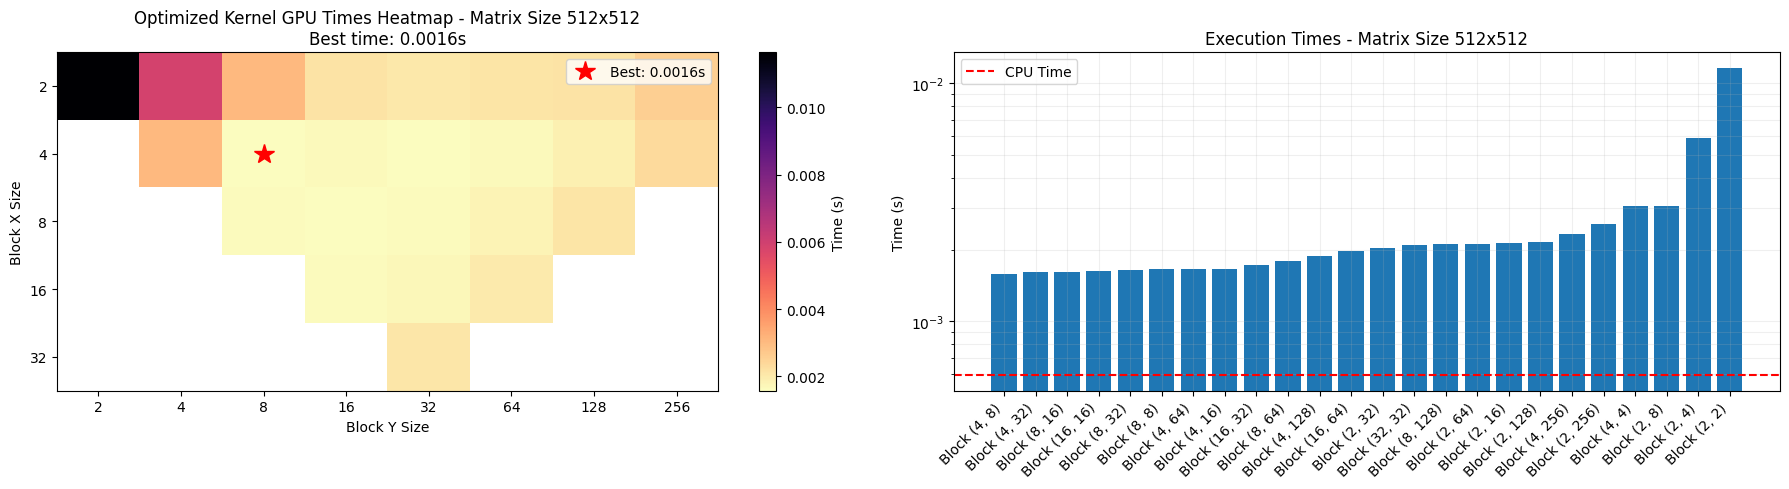

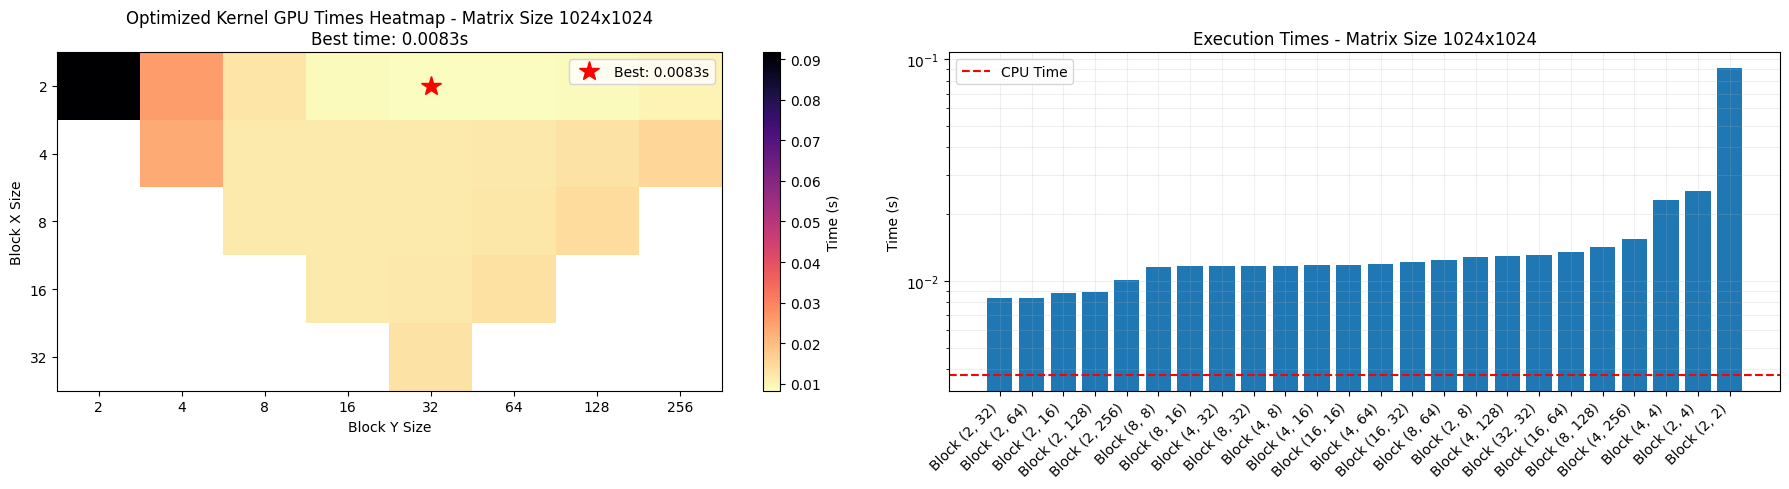

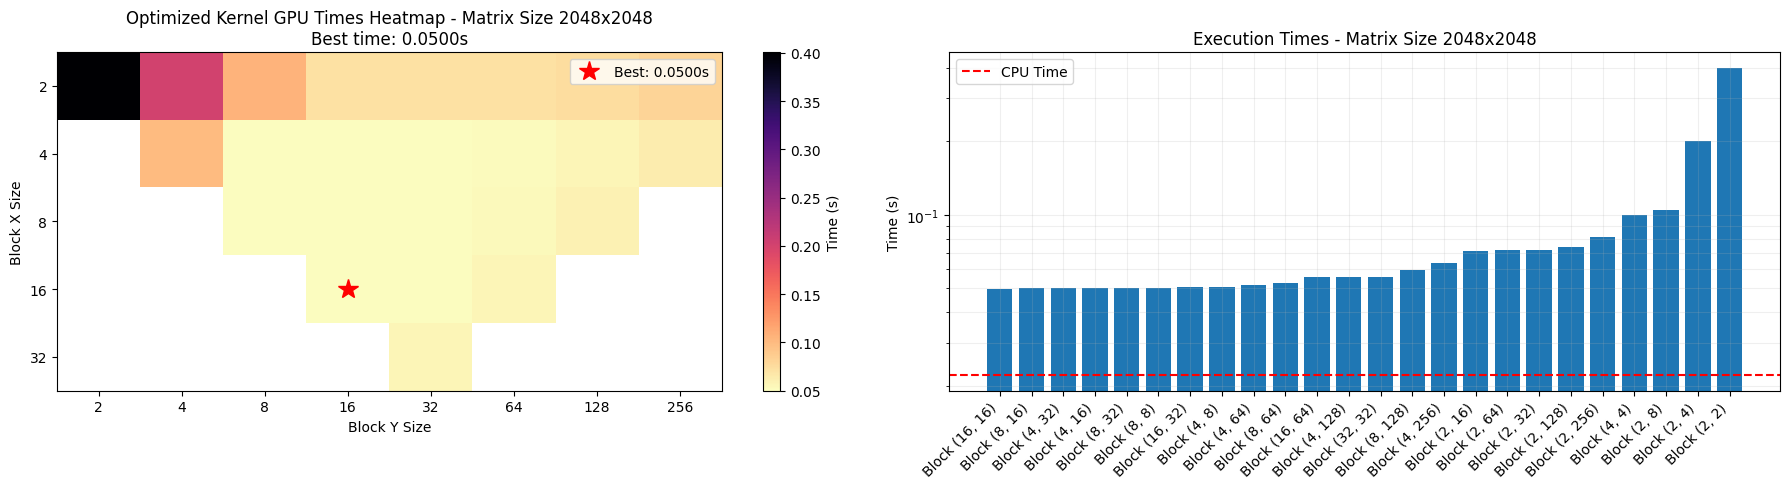

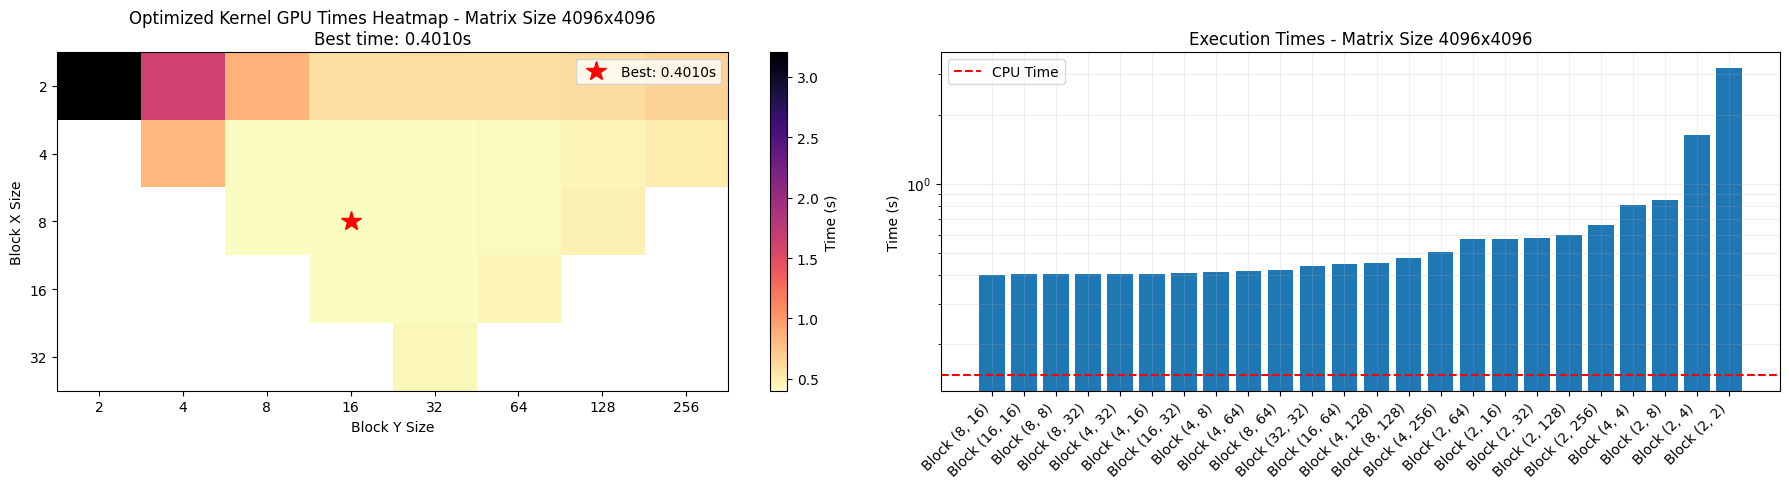

In [14]:
plot_results(results_optimized, 'Optimized Kernel')

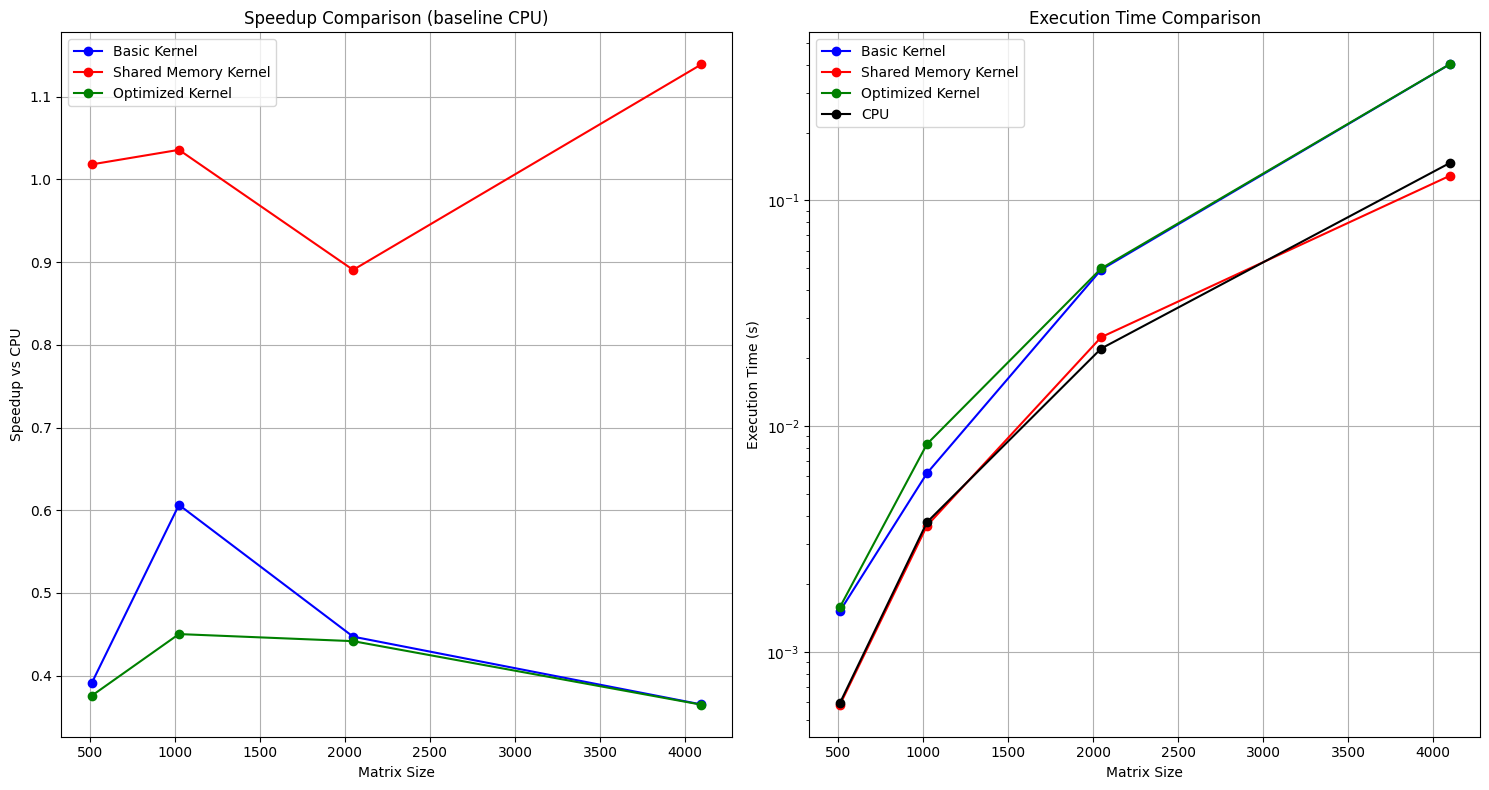


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Optimized Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0015    |    0.0006    |    0.0016    | (4, 8)
    1024     |    0.0062    |    0.0036    |    0.0083    | (2, 32)
    2048     |    0.0494    |    0.0248    |    0.0500    | (16, 16)
    4096     |    0.4007    |    0.1285    |    0.4010    | (8, 16)


In [15]:
best_times_optimized = {}
for N in matrix_sizes:
    optimized_N = [r for r in results_optimized if r['matrix_size'] == N]
    best_times_optimized[N] = min(optimized_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_optimized], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Optimized Kernel'],
                      matrix_sizes) 

#### 5.3 NVIDIA Profiler

Use a performance profiler from NVIDIA to identify bottlenecks in your code or to compare different implementations (blocks, memory, etc.).

* See example example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) for profiling the code and inspecting the results (latest version)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> You can install NVIDIA Nsights Systems and the Nvidia Visual Profiler on your PC and visualize the performance results from a remote instance, even if you don't have a GPU on/in your PC. To do this, you can generate the ``*.qdrep`` file and then load it locally.


Document your analysis with 1-2 visualizations if necessary and describe which bottlenecks you have found or mitigated.


##### Optimization

I started off with the optimized kernel from 5.2.3 and then used the ncu profiler to find the bottlenecks. This especially because the shared memory outperformed the original kernel by a lot, but my "optimized" kernel did not and actually performed worse than the base kernel. This definitely points to some issues with the kernel. 

See profiles/optimized_profile_original.ncu-rep 


The ncu profiles shows that 



In [16]:
def get_optimized_kernel_s_shared_fused(threads_per_block):
    blockDimX, blockDimY = threads_per_block

    @cuda.jit(fastmath=True)
    def tile_based_svd_kernel_s_shared(u, s, vt, C, k):
        row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

        if row >= C.shape[0] or col >= C.shape[1]:
            return

        tileU  = cuda.shared.array(shape=(blockDimY, blockDimX), dtype=float32)
        tileV  = cuda.shared.array(shape=(blockDimX, blockDimY), dtype=float32)
        s_tile = cuda.shared.array(shape=(blockDimX,), dtype=float32)

        # Force single-precision accumulator
        acc = float32(0.0)

        tile_count = (k + blockDimX - 1) // blockDimX
        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y

        for t in range(tile_count):
            k_base = t * blockDimX

            s_index = k_base + tx
            if s_index < k:
                s_tile[tx] = s[s_index]
            else:
                s_tile[tx] = float32(0.0)

            cuda.syncthreads()

            if row < u.shape[0] and s_index < k:
                tileU[ty, tx] = u[row, s_index] * s_tile[tx]
            else:
                tileU[ty, tx] = float32(0.0)

            v_index = k_base + ty
            if v_index < vt.shape[0] and col < vt.shape[1]:
                tileV[tx, ty] = vt[v_index, col]
            else:
                tileV[tx, ty] = float32(0.0)

            cuda.syncthreads()

            for n in range(blockDimX):
                acc += tileU[ty, n] * tileV[n, tx]

            cuda.syncthreads()

        C[row, col] = acc

    return tile_based_svd_kernel_s_shared

In [17]:

results_optimized_fused = []

for N in matrix_sizes:
    u = svd_components[N]['u']
    s = svd_components[N]['s']
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']
    
    u_dev  = cuda.to_device(u)
    s_dev  = cuda.to_device(s)
    vt_dev = cuda.to_device(vt)
    C_dev  = cuda.device_array((N, N), dtype=np.float32)

    cuda.synchronize()

    for block_size in block_configs:
        blockDimX, blockDimY = block_size
        gridX = math.ceil(N / blockDimX)
        gridY = math.ceil(N / blockDimY)
        grid  = (gridX, gridY)

        kernel = get_optimized_kernel_s_shared_fused(block_size)

        # Warm-up
        kernel[grid, block_size](u_dev, s_dev, vt_dev, C_dev, k)
        cuda.synchronize()

        start_event = cuda.event()
        stop_event  = cuda.event()

        start_event.record()
        kernel[grid, block_size](u_dev, s_dev, vt_dev, C_dev, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000.0

        C_host = C_dev.copy_to_host()
        cuda.synchronize()

        speedup = svd_components[N]['cpu_time'] / gpu_time

        results_optimized_fused.append({
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })

        print(f"[N={N}] block={block_size} GPU={gpu_time:.5f}s CPU={svd_components[N]['cpu_time']:.5f}s speedup={speedup:.2f}x")

    del u_dev, s_dev, vt_dev, C_dev


[N=512] block=(2, 2) GPU=0.00702s CPU=0.00059s speedup=0.08x
[N=512] block=(2, 4) GPU=0.00426s CPU=0.00059s speedup=0.14x
[N=512] block=(2, 8) GPU=0.00301s CPU=0.00059s speedup=0.20x
[N=512] block=(2, 16) GPU=0.00224s CPU=0.00059s speedup=0.26x
[N=512] block=(2, 32) GPU=0.00204s CPU=0.00059s speedup=0.29x
[N=512] block=(2, 64) GPU=0.00188s CPU=0.00059s speedup=0.32x
[N=512] block=(2, 128) GPU=0.00187s CPU=0.00059s speedup=0.32x
[N=512] block=(2, 256) GPU=0.00194s CPU=0.00059s speedup=0.31x
[N=512] block=(4, 4) GPU=0.00132s CPU=0.00059s speedup=0.45x
[N=512] block=(4, 8) GPU=0.00091s CPU=0.00059s speedup=0.65x
[N=512] block=(4, 16) GPU=0.00083s CPU=0.00059s speedup=0.71x
[N=512] block=(4, 32) GPU=0.00083s CPU=0.00059s speedup=0.72x
[N=512] block=(4, 64) GPU=0.00084s CPU=0.00059s speedup=0.71x
[N=512] block=(4, 128) GPU=0.00086s CPU=0.00059s speedup=0.69x
[N=512] block=(4, 256) GPU=0.00104s CPU=0.00059s speedup=0.57x
[N=512] block=(8, 8) GPU=0.00049s CPU=0.00059s speedup=1.22x
[N=512] bl

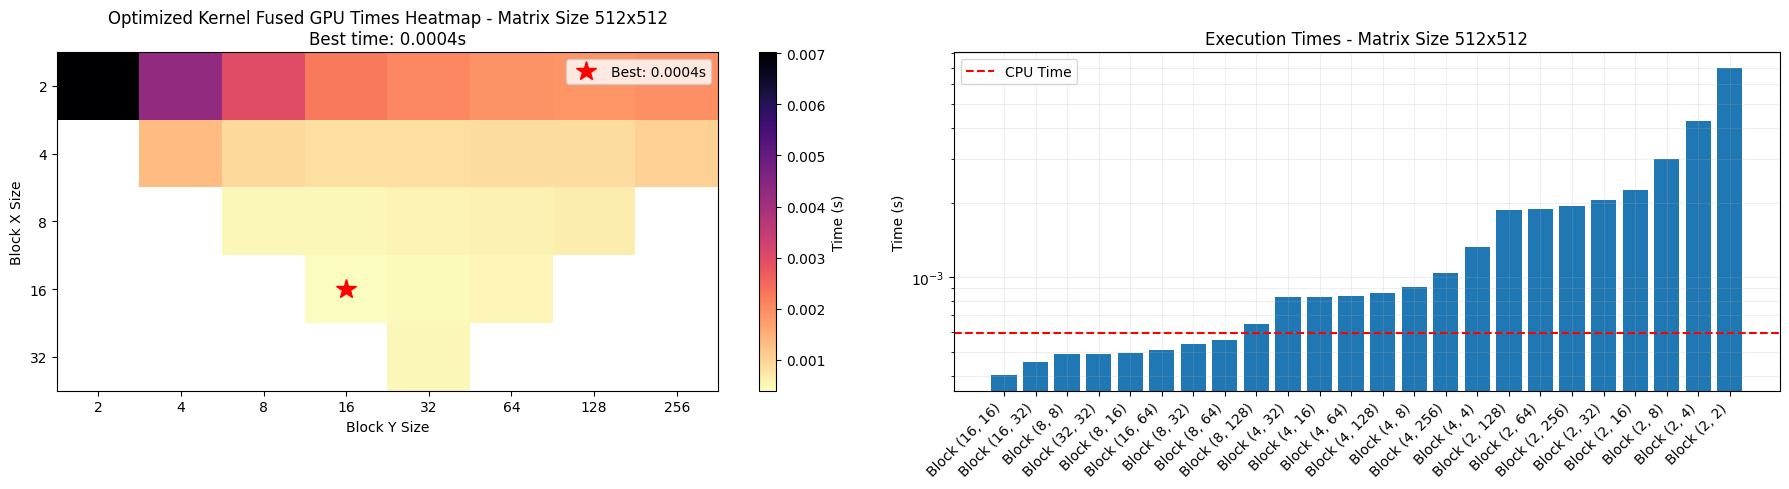

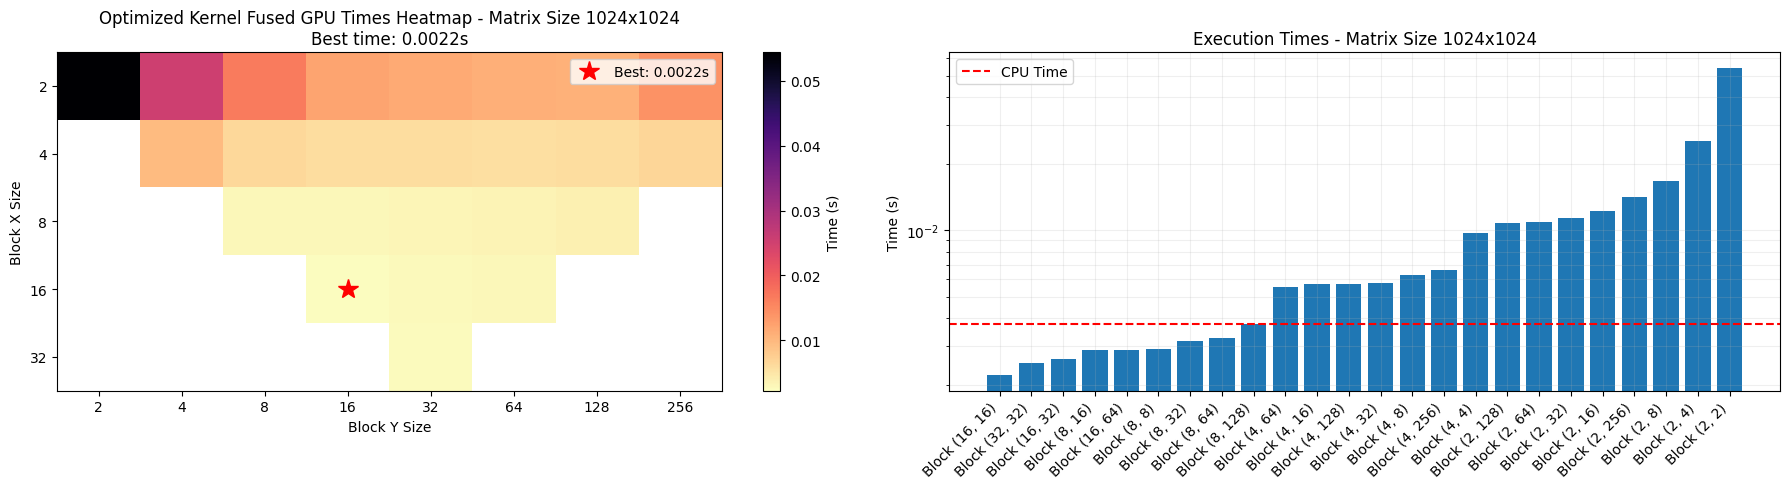

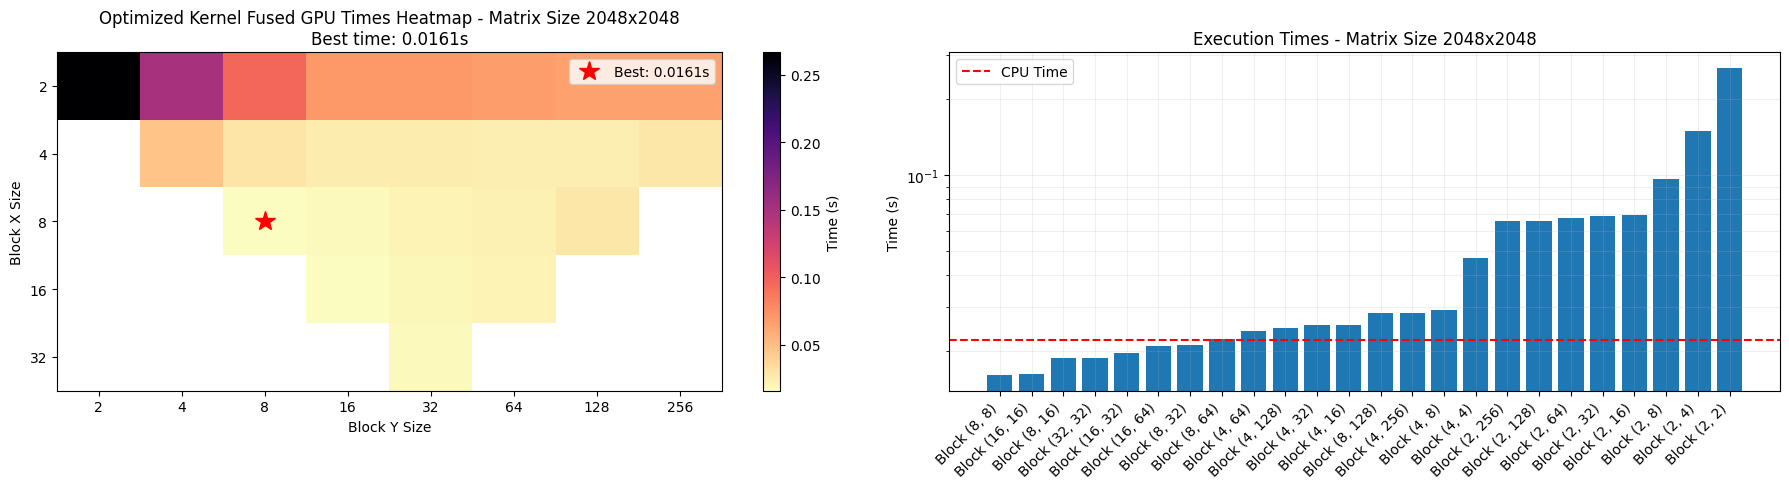

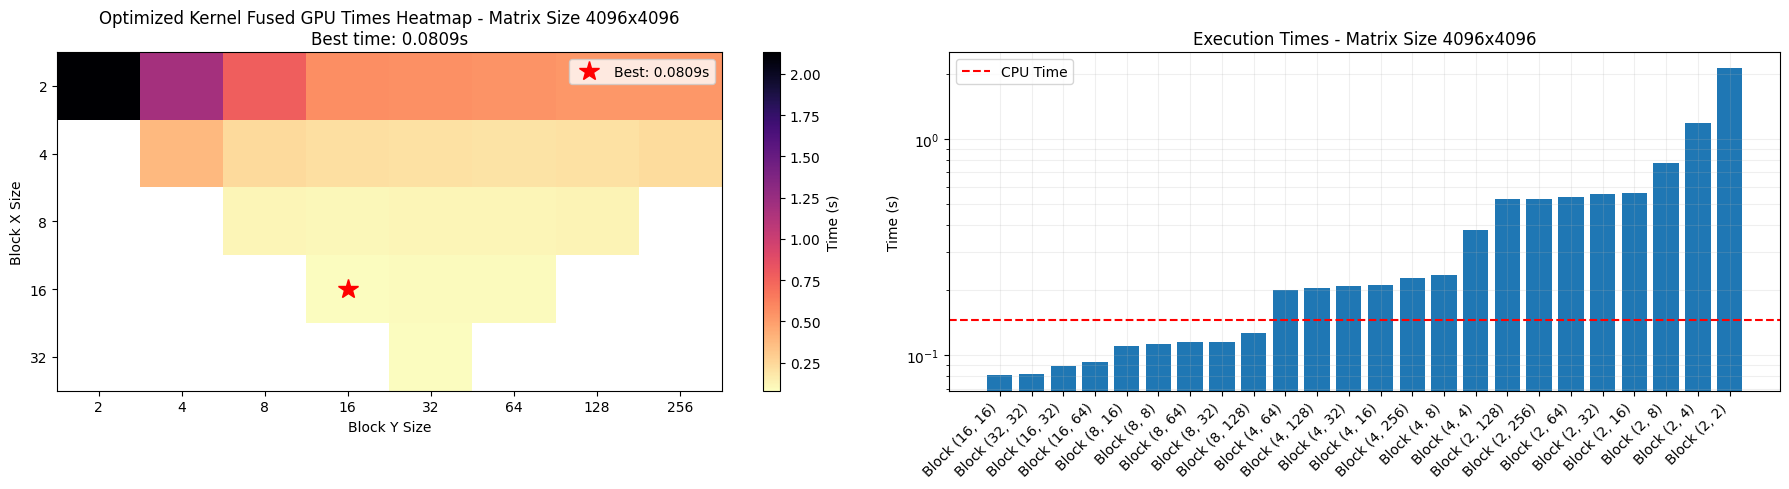

In [18]:
plot_results(results_optimized_fused, 'Optimized Kernel Fused')

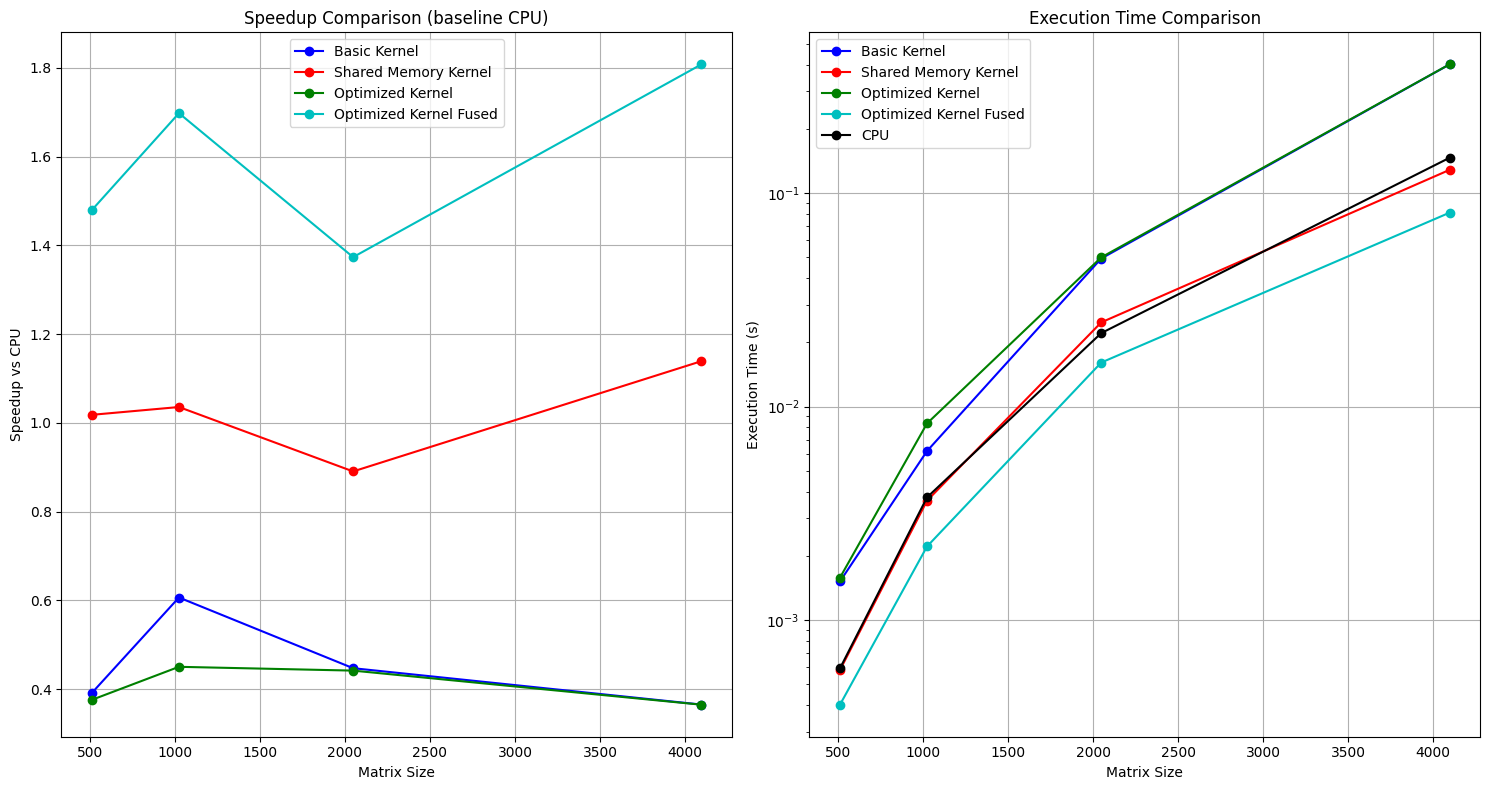


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Optimized Kernel Time | Optimized Kernel Fused Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0015    |    0.0006    |    0.0016    |    0.0004    | (16, 16)
    1024     |    0.0062    |    0.0036    |    0.0083    |    0.0022    | (16, 16)
    2048     |    0.0494    |    0.0248    |    0.0500    |    0.0161    | (8, 8)
    4096     |    0.4007    |    0.1285    |    0.4010    |    0.0809    | (16, 16)


In [19]:
best_times_optimized_fused = {}
for N in matrix_sizes:
    optimized_fused_N = [r for r in results_optimized_fused if r['matrix_size'] == N]
    best_times_optimized_fused[N] = min(optimized_fused_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_optimized, best_times_optimized_fused], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Optimized Kernel', 'Optimized Kernel Fused'],
                      matrix_sizes) 

In [ ]:
def get_optimized_kernel_padding(threads_per_block):

    blockDimX, blockDimY = threads_per_block

    @cuda.jit(fastmath=True)
    def tile_based_svd_kernel_s_shared(u, s, vt, C, k):
        # Access dynamic shared memory as a 1D buffer
        shared_mem = cuda.shared.array(0, float32)

        # Precompute chunk sizes
        tileU_size  = blockDimY * (blockDimX + 1)  # +1 to reduce bank conflicts
        tileV_size  = blockDimX * (blockDimY + 1)
        s_tile_size = blockDimX
        total_size  = tileU_size + tileV_size + s_tile_size

        # Partition the 1D buffer
        tileU_1d  = shared_mem[0 : tileU_size]
        tileV_1d  = shared_mem[tileU_size : tileU_size + tileV_size]
        s_tile_1d = shared_mem[tileU_size + tileV_size : total_size]

        # Map thread to global row/col
        row = cuda.blockIdx.y * blockDimY + cuda.threadIdx.y
        col = cuda.blockIdx.x * blockDimX + cuda.threadIdx.x

        if row >= C.shape[0] or col >= C.shape[1]:
            return

        # Accumulator
        acc = float32(0.0)
        tile_count = (k + blockDimX - 1) // blockDimX

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y

        for t in range(tile_count):
            k_base = t * blockDimX
            s_idx  = k_base + tx

            # 1) Load s_tile
            if s_idx < k:
                s_tile_1d[tx] = s[s_idx]
            else:
                s_tile_1d[tx] = float32(0.0)

            cuda.syncthreads()

            # 2) tileU: row-based => ty * (blockDimX+1) + tx
            #    Multiply U by s_tile
            u_index_1d = ty * (blockDimX + 1) + tx
            if (row < u.shape[0]) and (s_idx < k):
                val_s = s_tile_1d[tx]
                tileU_1d[u_index_1d] = u[row, s_idx] * val_s
            else:
                tileU_1d[u_index_1d] = float32(0.0)

            # 3) tileV: col-based => tx * (blockDimY+1) + ty
            v_index_1d = tx * (blockDimY + 1) + ty
            v_idx = k_base + ty
            if v_idx < vt.shape[0] and col < vt.shape[1]:
                tileV_1d[v_index_1d] = vt[v_idx, col]
            else:
                tileV_1d[v_index_1d] = float32(0.0)

            cuda.syncthreads()

            # 4) Dot product across blockDimX
            #    tileU_1d[ty*(blockDimX+1) + n] * tileV_1d[n*(blockDimY+1) + tx]
            for n in range(blockDimX):
                acc += tileU_1d[ty * (blockDimX + 1) + n] * tileV_1d[n * (blockDimY + 1) + tx]

            cuda.syncthreads()

        C[row, col] = acc

    return tile_based_svd_kernel_s_shared


## 6 Accelerated reconstruction of multiple images
#### 6.1 Implementation
Use some of the concepts you have learned so far to reconstruct multiple images in parallel. Why did you use which concepts for your implementation? Try to utilize the GPU constantly and thus use the different engines of the GPU in parallel. Investigate this also for larger inputs than the MRI images.

## 7 Reflection

Reflect on the following topics by giving reasons in 3-5 sentences and explaining them using examples.

1: In your opinion, what are the 3 most important principles in accelerating code?

**Answer:**

1. **Optimizing Memory Access**: Efficient use of memory hierarchies to reduce latency.
2. **Exploiting Parallelism**: Leveraging multi-threading and vectorization to perform computations concurrently.
3. **Algorithm Efficiency**: Choosing or designing algorithms that minimize computational complexity.

2: Which computational architectures of Flynn's taxonomy were used in this mini-challenge and how?

**Answer:**

- **SISD (Single Instruction, Single Data)**: Standard sequential code execution on the CPU.
- **SIMD (Single Instruction, Multiple Data)**: GPU computations where the same instruction is applied to multiple data points simultaneously.
- **MIMD (Multiple Instruction, Multiple Data)**: If multi-threading on CPU was used, different instructions operating on different data.

3: Are we mainly dealing with CPU or IO bound problems in this mini-challenge? Give examples.

**Answer:**

We are mainly dealing with CPU-bound (computation-bound) problems. The primary challenge is the intensive computations required for SVD and matrix operations. For example, reconstructing images using SVD on large datasets is computationally heavy, while I/O operations like loading images are relatively fast.

4: How could this application be designed in a producer-consumer design?

**Answer:**

By implementing a producer-consumer model:

- **Producer**: Reads and preprocesses images, placing them into a queue.
- **Consumer**: Retrieves images from the queue and performs GPU reconstruction.

This allows overlapping of I/O and computation, improving resource utilization and throughput.

5: What are the most important basics to achieve more performance on the GPU in this mini-challenge?

**Answer:**

- **Memory Optimization**: Utilizing shared memory and minimizing global memory accesses.
- **Maximizing Parallelism**: Designing kernels that allow high occupancy and efficient thread utilization.
- **Reducing Data Transfer Overhead**: Keeping data on the GPU to avoid costly transfers between CPU and GPU.

6: Reflect on the mini-challenge. What went well? Where were there problems? Where did you need more time than planned? What did you learn? What surprised you? What else would you have liked to learn? Would you formulate certain questions differently? If so, how?

**Answer:**

The mini-challenge was insightful. Successfully implemented GPU acceleration and learned about memory optimization. Faced challenges with debugging GPU code and optimizing performance. Spent more time than planned on understanding GPU architectures. Learned the importance of efficient memory access patterns. Surprised by the significant speedup achievable. Would have liked to explore advanced GPU features. Some questions could provide more guidance on expected results.